In [1]:
import numpy as np
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
from copy import copy
from datetime import datetime, timedelta

from stonesoup.functions import gm_reduce_single

from stonesoup.predictor.kalman import KalmanPredictor
from stonesoup.updater.kalman import KalmanUpdater
from stonesoup.predictor.imm import IMMPredictor
from stonesoup.updater.imm import IMMUpdater
from stonesoup.models.transition.linear import ConstantVelocity, \
    CombinedLinearGaussianTransitionModel, RandomWalk, OrnsteinUhlenbeck

from stonesoup.models.measurement.linear import LinearGaussian

from stonesoup.types.state import GaussianState
from stonesoup.types.hypothesis import SingleHypothesis
from stonesoup.types.detection import Detection
from stonesoup.types.state import StateVector, CovarianceMatrix, \
    GaussianMixtureState, WeightedGaussianState
from stonesoup.types.track import Track

from stonesoup.simulator.simple import SingleTargetGroundTruthSimulator

from matplotlib.patches import Ellipse


In [2]:
from bayou.datastructures import Gaussian as EMGPB2Gaussian
from bayou.datastructures import GMM as EMGPB2GMM
from bayou.datastructures import GMMSequence as EMGPB2GMMSequence
from bayou.models import LinearModel as EMGPB2LinearModel
from bayou.models import ConstantVelocity as EMGPB2ConstantVelocity
from bayou.expmax.skf import SKF

Plot function

In [3]:
def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the
    ellipse patch artist.
    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.
    Returns
    -------
        A matplotlib ellipse artist
    """

    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:, order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta,
                    **kwargs)

    ax.add_artist(ellip)
    return ellip


Groundtruth and detections

In [4]:
gt_transition_model_1 = CombinedLinearGaussianTransitionModel(
                        (ConstantVelocity(0.1),
                         ConstantVelocity(0.1)))
gt_transition_model_2 = CombinedLinearGaussianTransitionModel(
                        (ConstantVelocity(0.4),
                         ConstantVelocity(0.4)))

gt_track = []
gt_time = []
timestamp_init = datetime.now()
state_init_1 = GaussianState(StateVector([[0], [0], [0], [0]]),
                           CovarianceMatrix(np.diag([0.0, 0.0, 0.0, 0.0])),
                           timestamp=timestamp_init)
gt_generator_1 = SingleTargetGroundTruthSimulator(gt_transition_model_1, state_init_1, number_steps=100)

for time, gnd_paths in gt_generator_1.groundtruth_paths_gen():
    gnd_path = gnd_paths.pop()
    gt_track.append(gnd_path.state)
    gt_time.append(time)

#print(gt_track)

state_init_2 = GaussianState(gt_track[-1].state_vector,
                           CovarianceMatrix(np.diag([0.0, 0.0, 0.0, 0.0])),
                           timestamp=gt_time[-1])
gt_generator_2 = SingleTargetGroundTruthSimulator(gt_transition_model_2, state_init_2, number_steps=100)
for time, gnd_paths in gt_generator_2.groundtruth_paths_gen():
    gnd_path = gnd_paths.pop()
    gt_track.append(gnd_path.state)
    gt_time.append(time)

mesurement_noise = np.diag([3.0 ** 2, 3.0 ** 2])
measurement_model = LinearGaussian(ndim_state=4, mapping=[0, 2], noise_covar=mesurement_noise)

detection_track = []
for i in range(len(gt_time)):
    m_ = Detection(measurement_model.function(gt_track[i].state_vector, measurement_model.rvs(1)), gt_time[i])
    detection_track.append(m_)
# print(gt_track)
# print(detection_track)

Filter model. Testing without EMGPB2 estimated parameters.

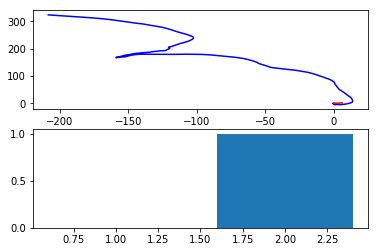

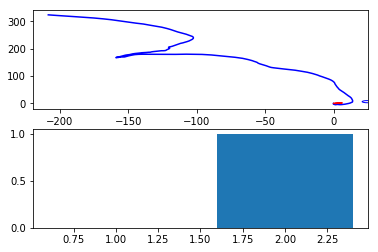

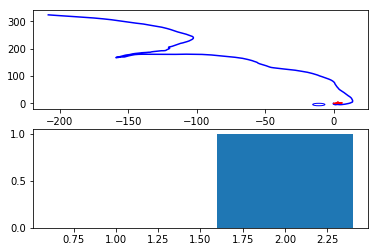

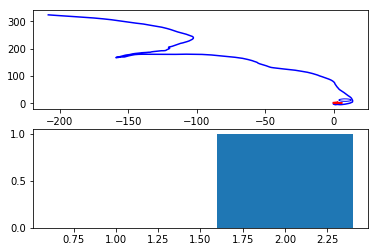

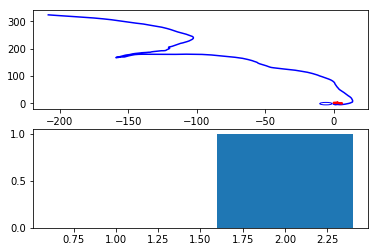

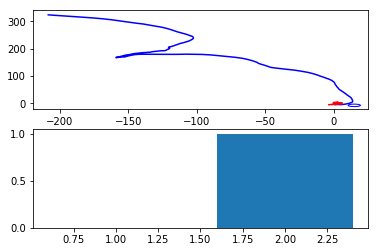

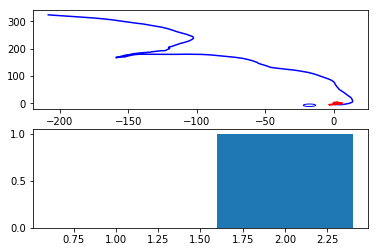

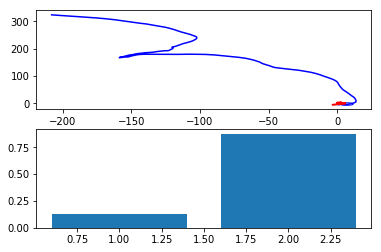

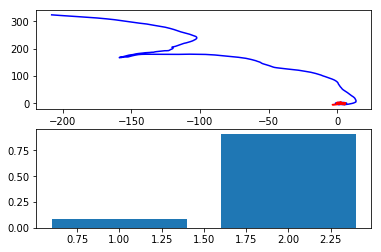

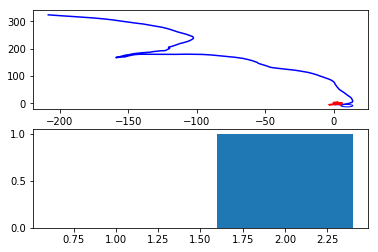

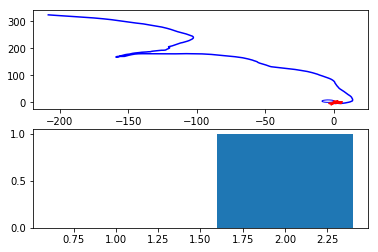

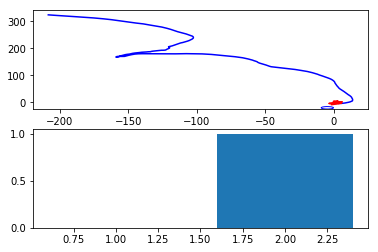

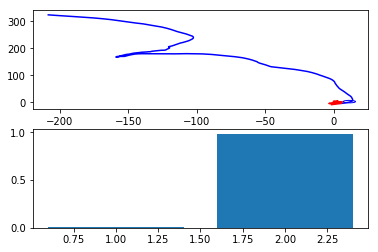

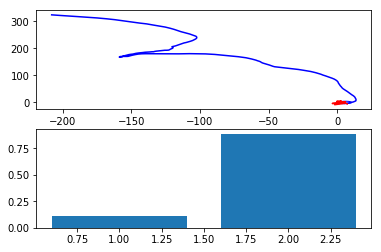

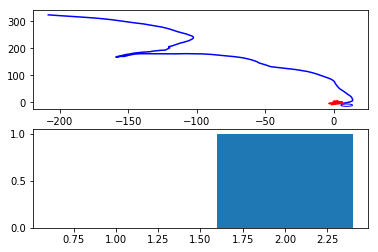

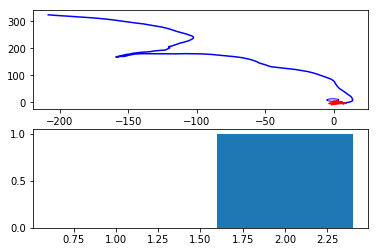

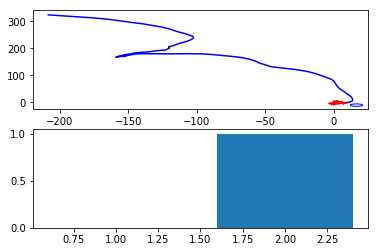

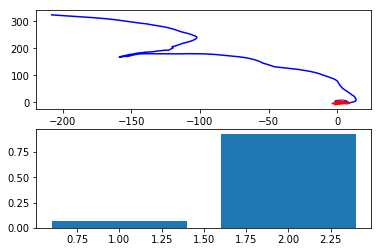

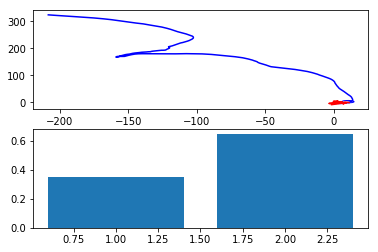

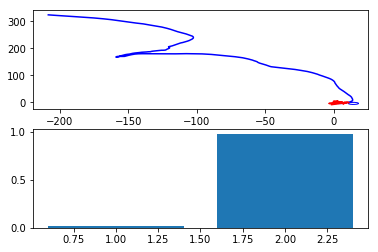

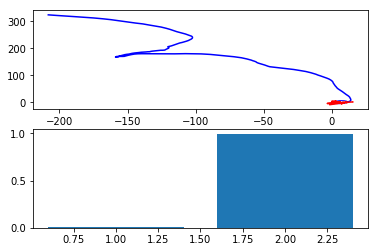

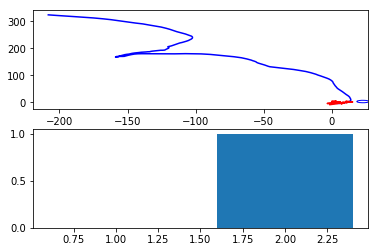

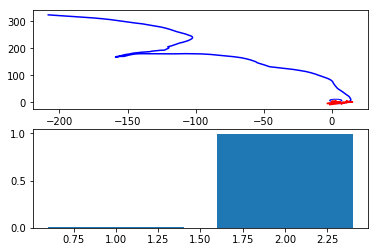

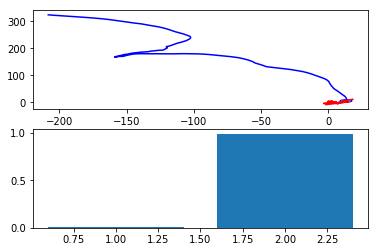

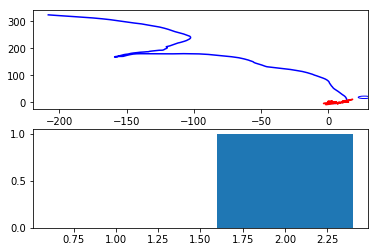

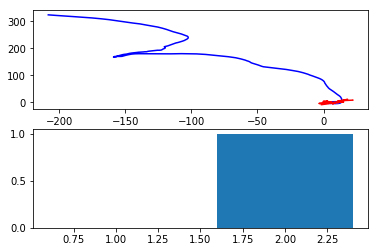

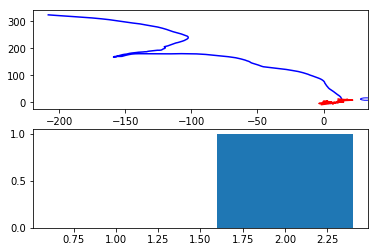

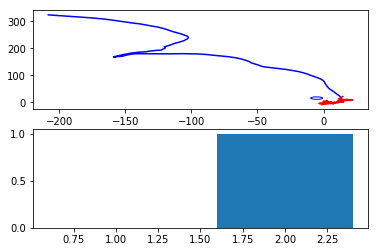

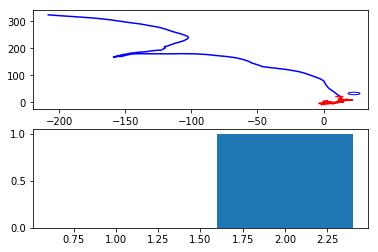

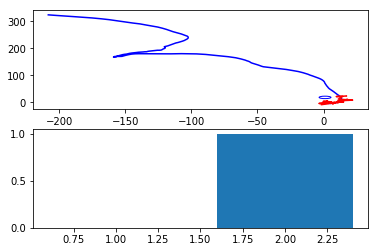

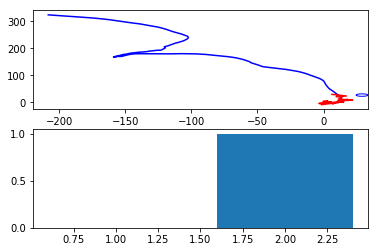

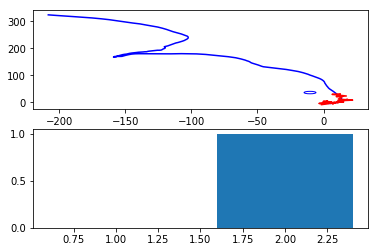

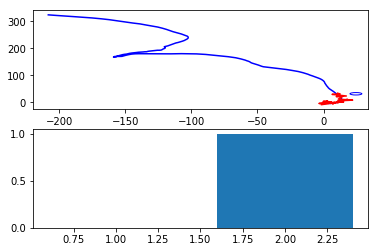

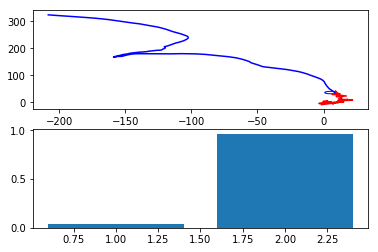

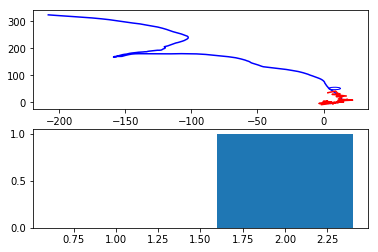

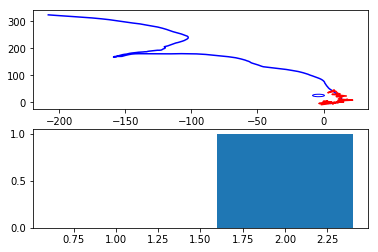

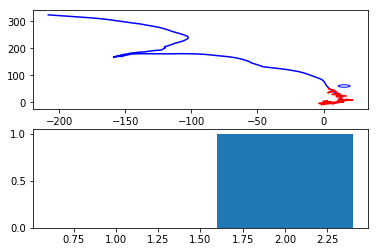

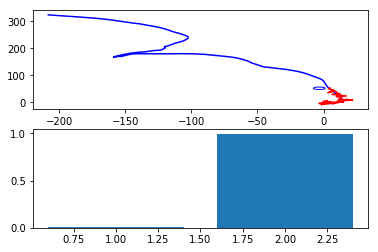

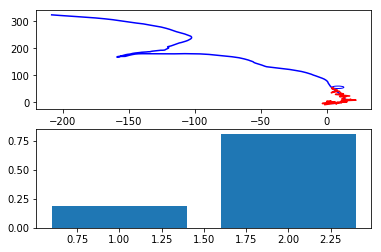

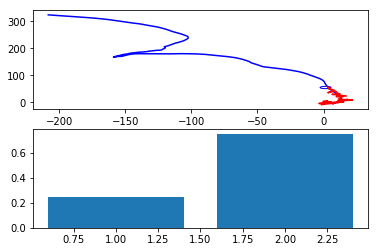

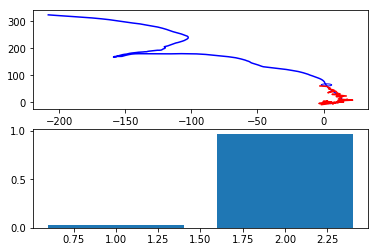

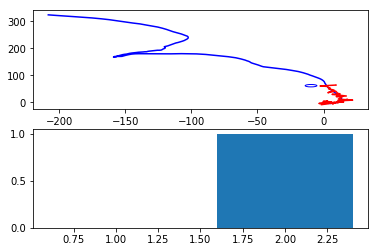

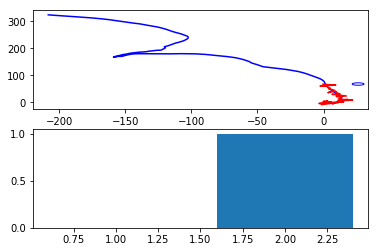

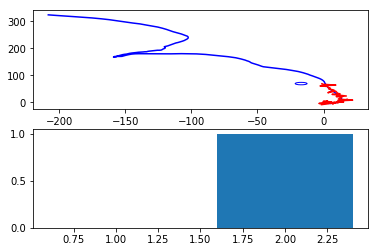

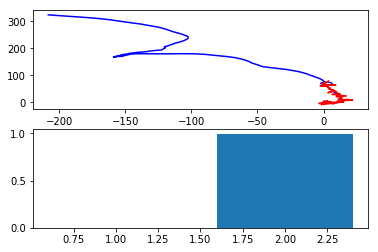

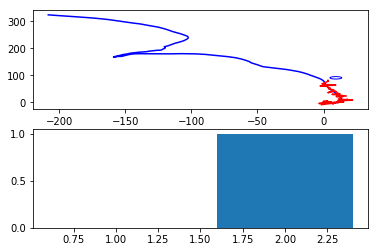

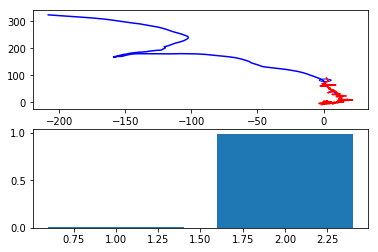

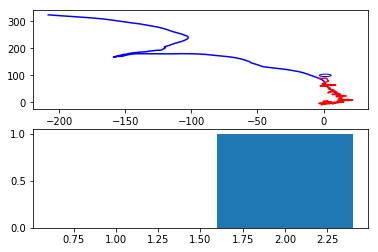

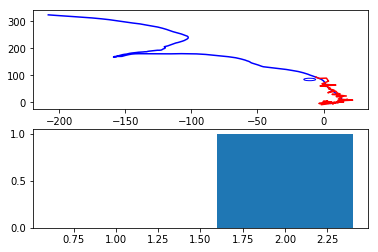

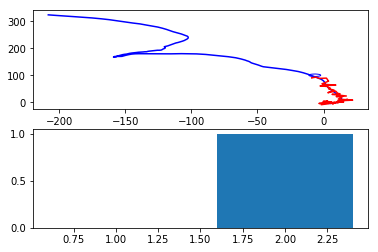

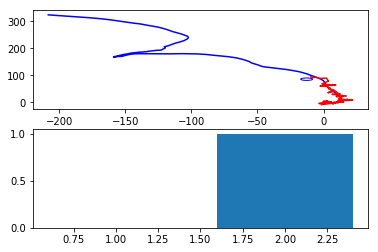

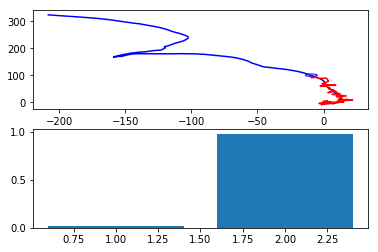

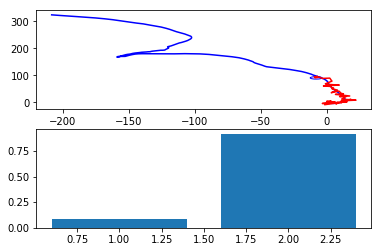

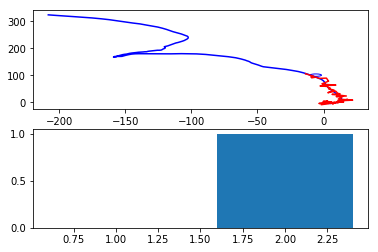

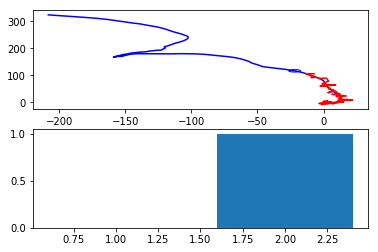

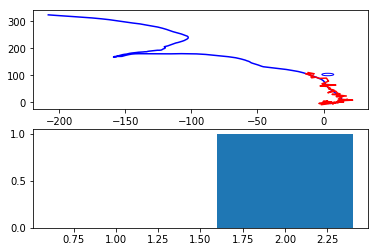

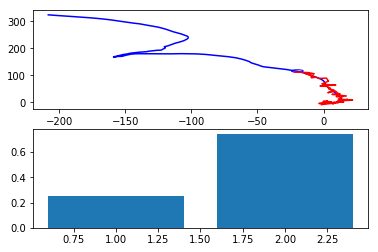

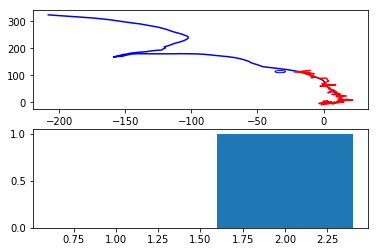

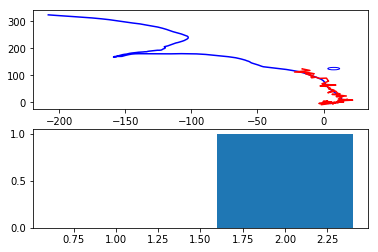

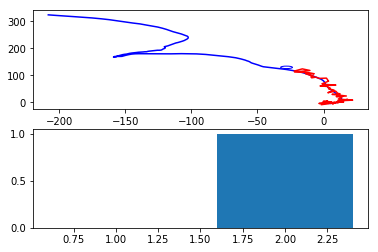

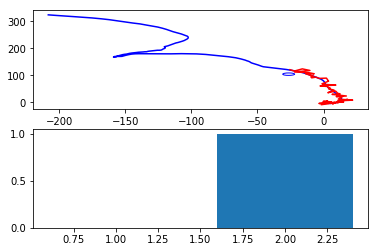

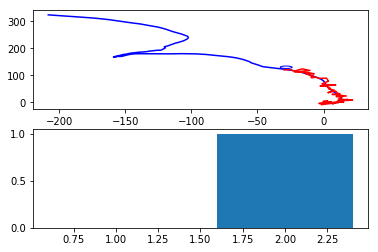

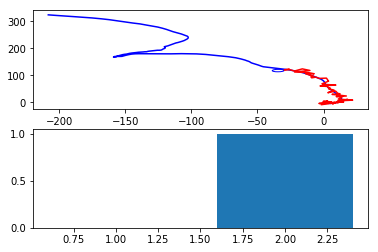

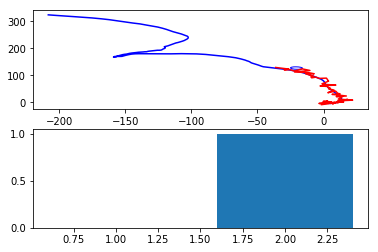

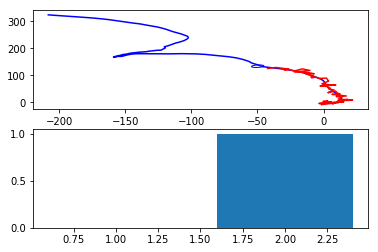

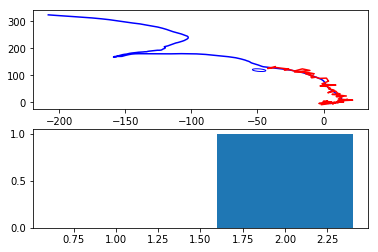

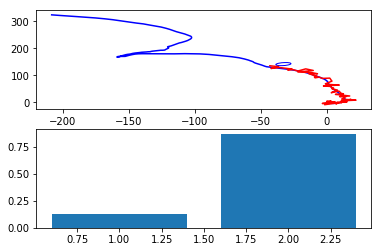

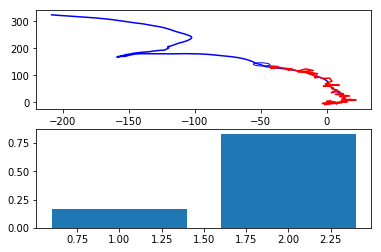

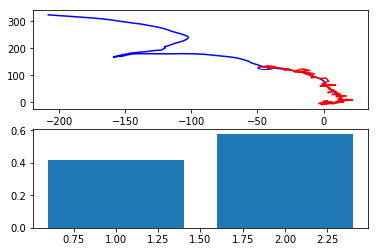

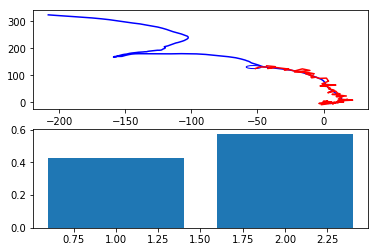

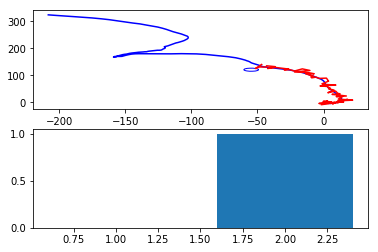

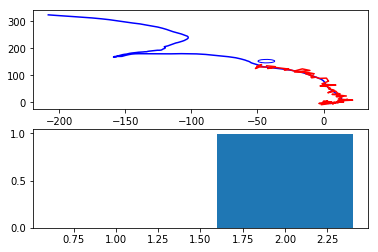

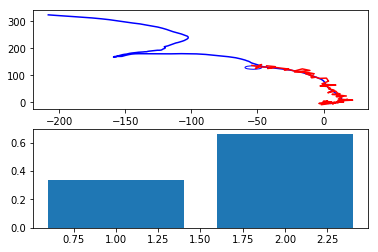

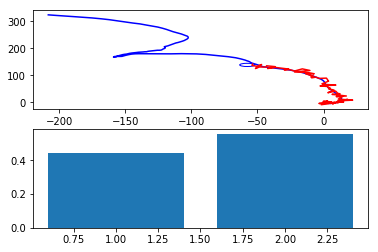

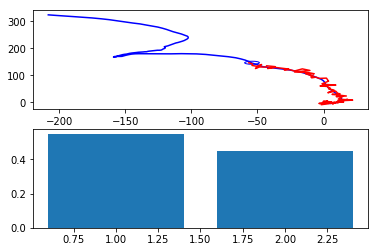

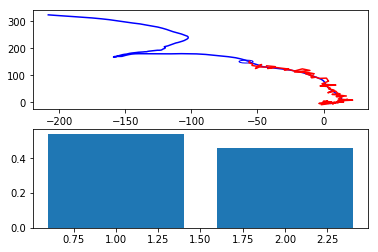

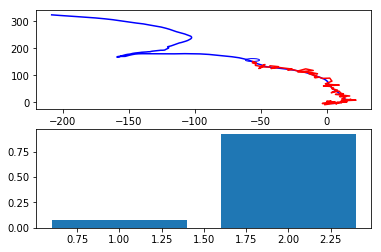

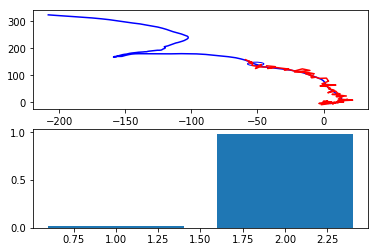

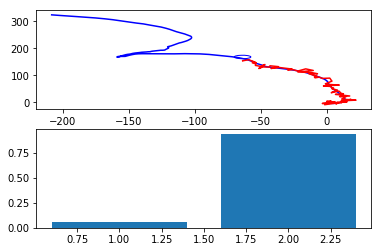

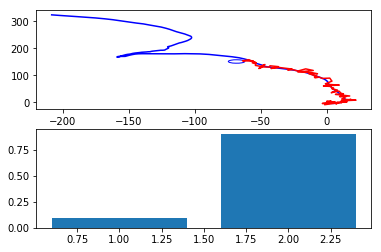

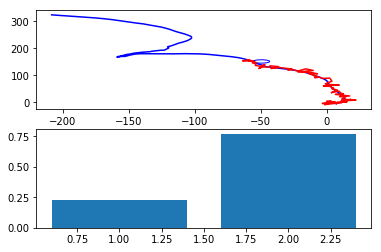

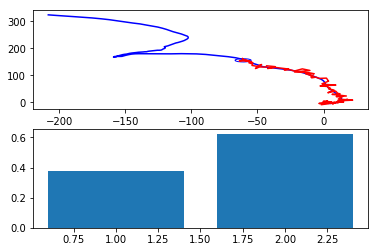

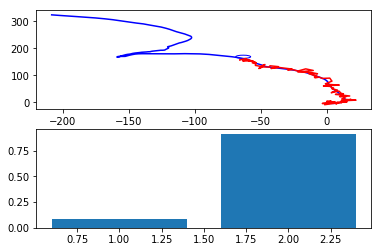

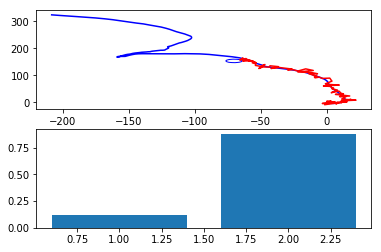

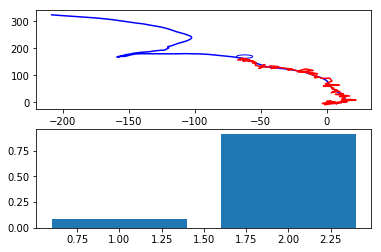

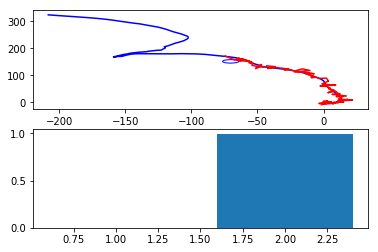

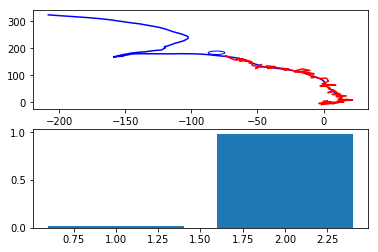

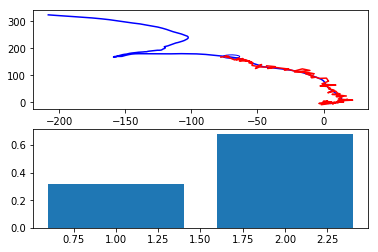

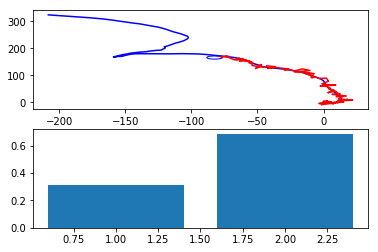

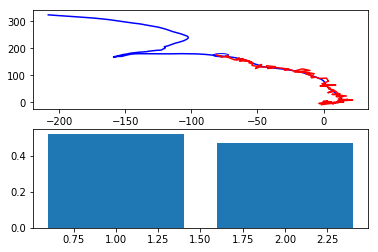

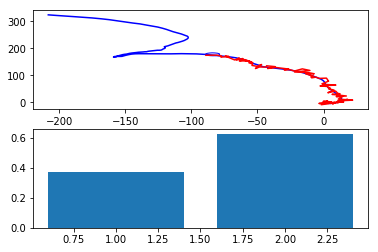

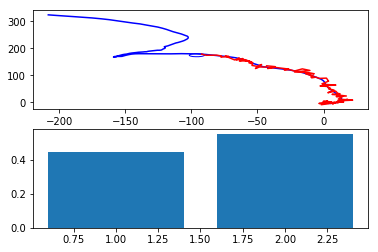

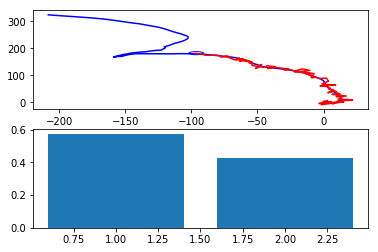

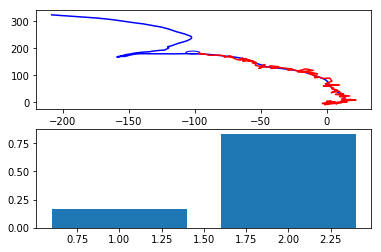

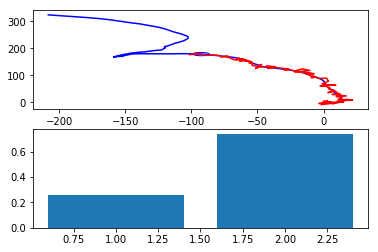

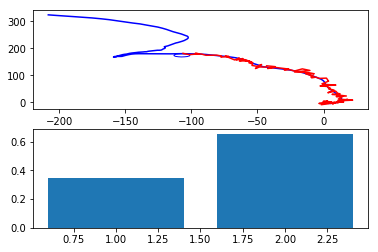

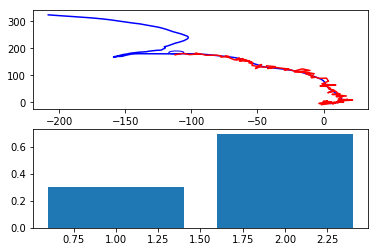

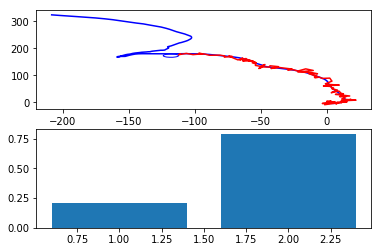

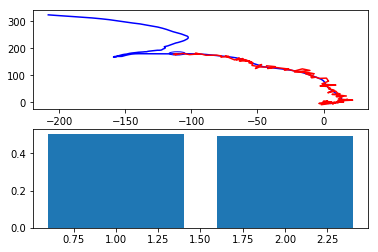

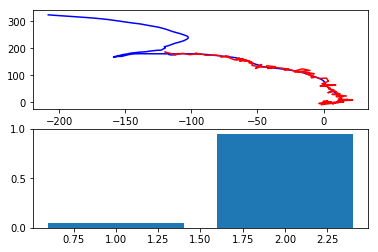

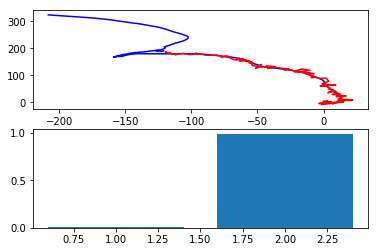

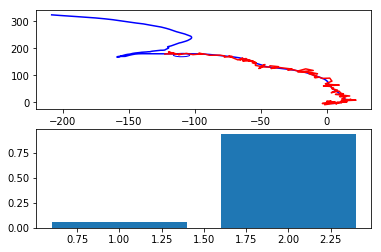

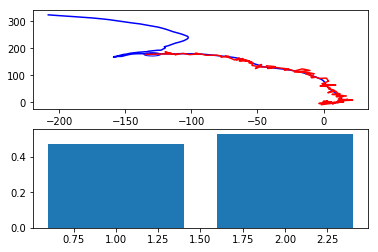

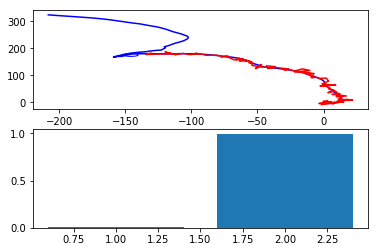

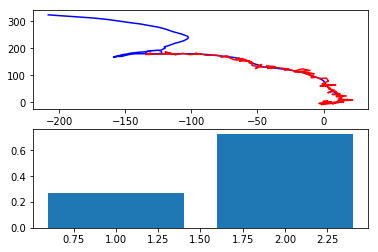

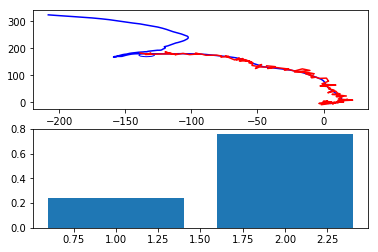

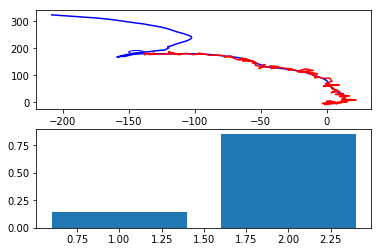

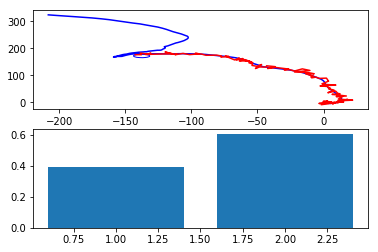

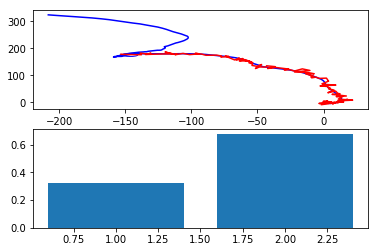

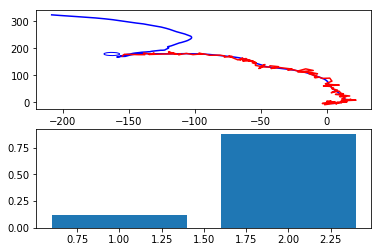

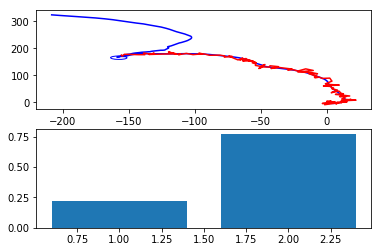

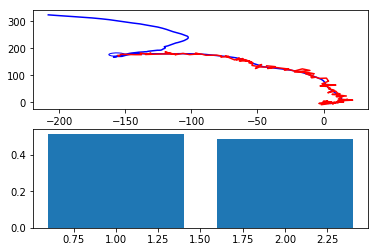

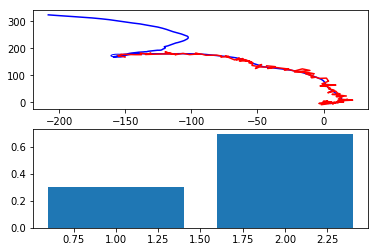

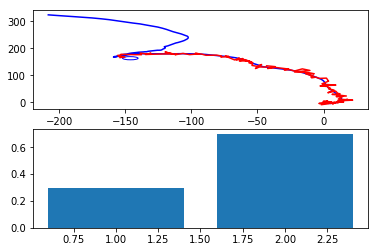

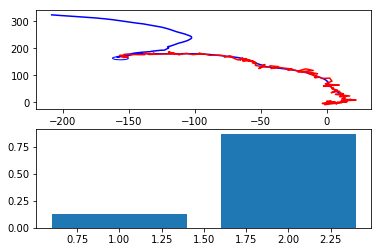

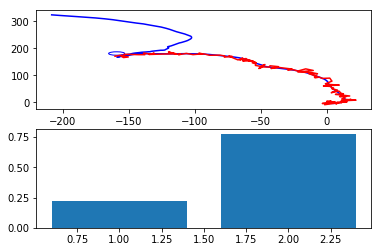

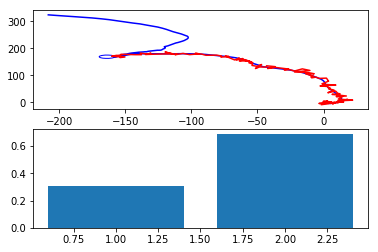

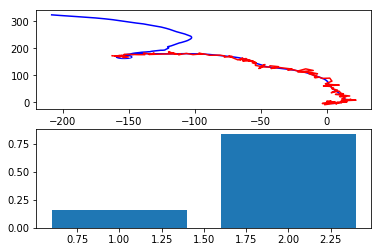

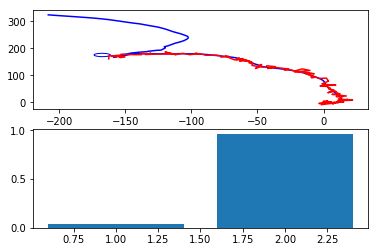

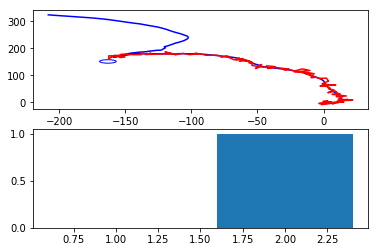

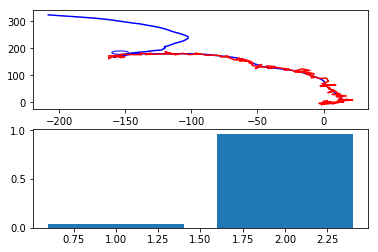

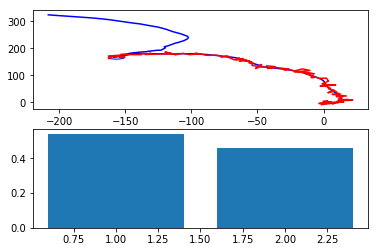

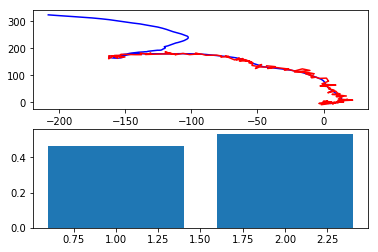

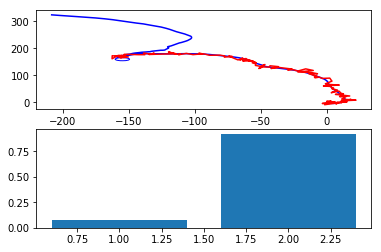

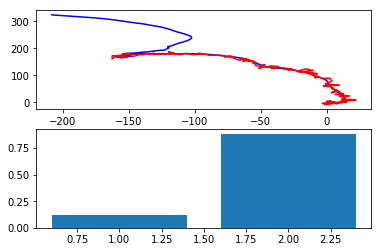

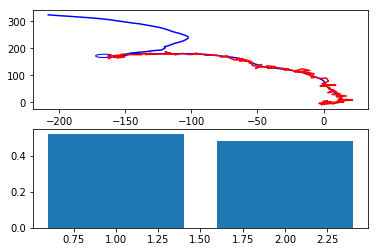

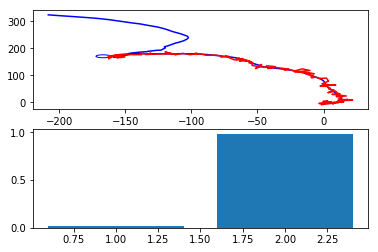

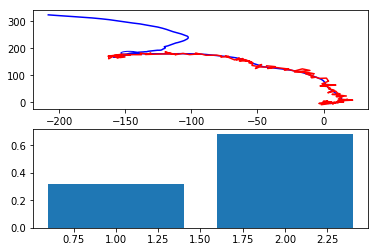

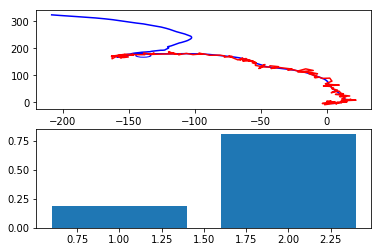

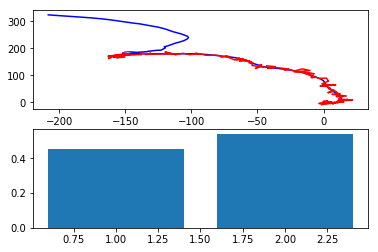

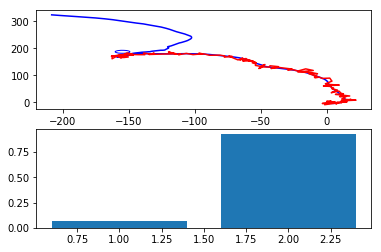

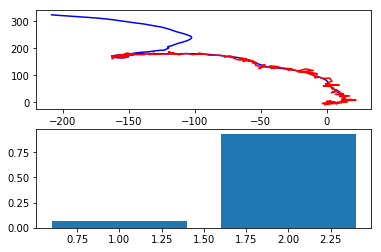

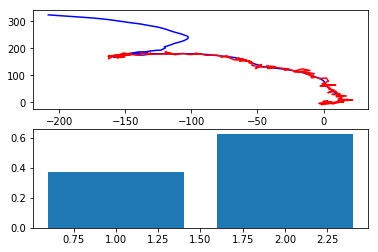

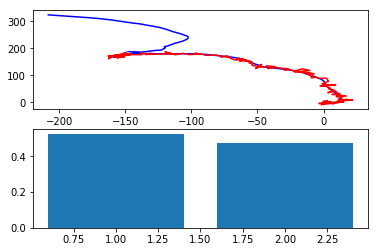

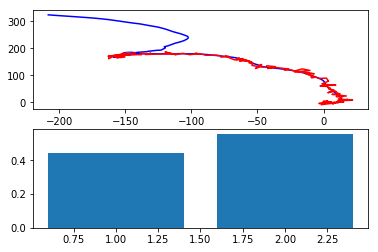

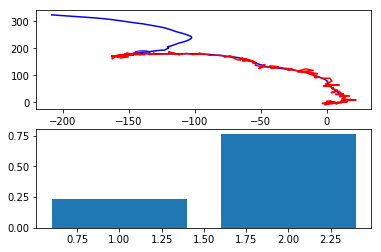

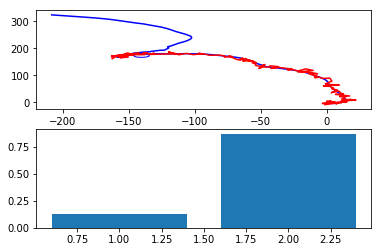

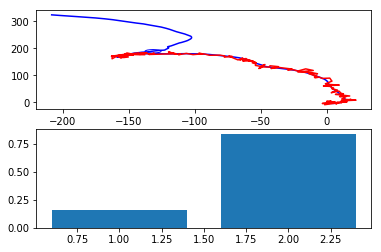

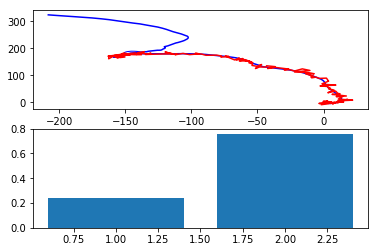

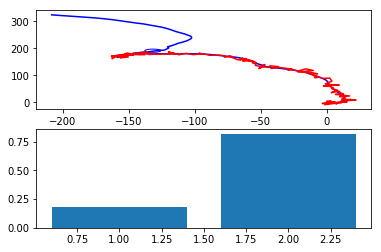

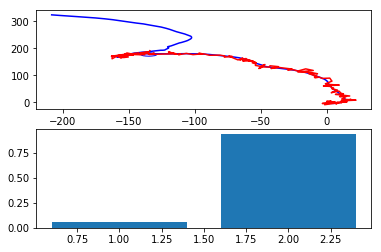

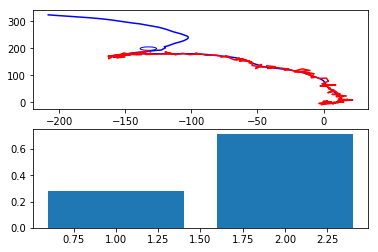

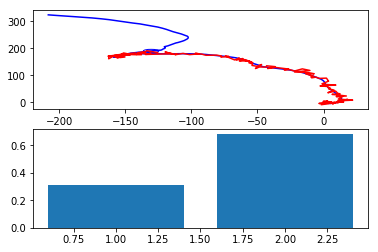

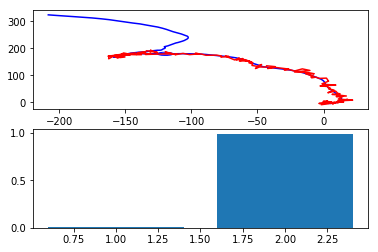

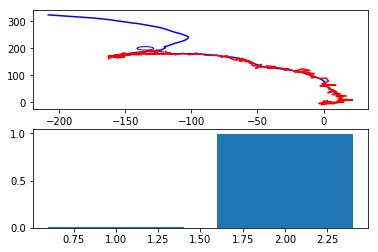

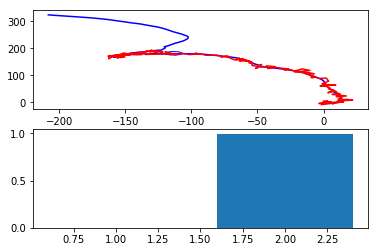

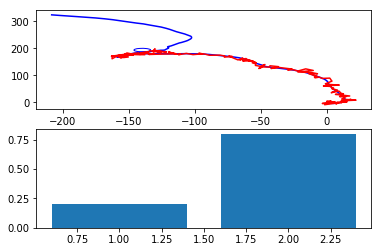

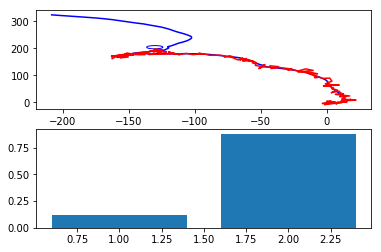

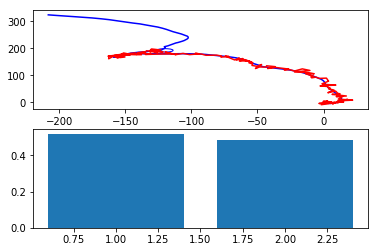

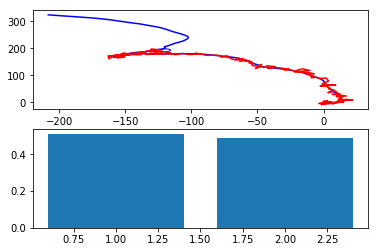

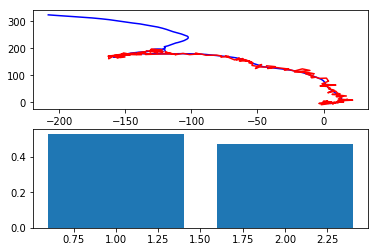

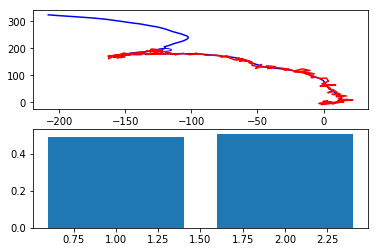

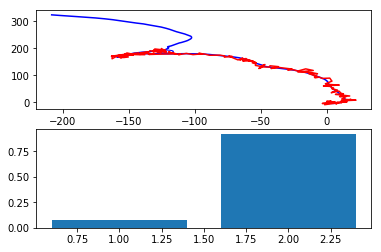

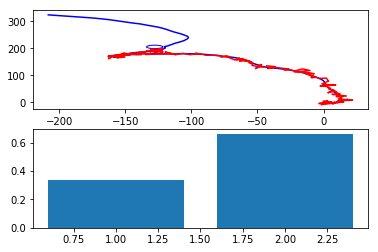

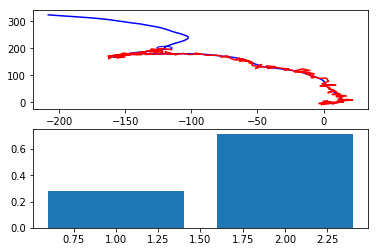

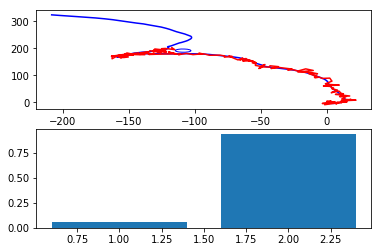

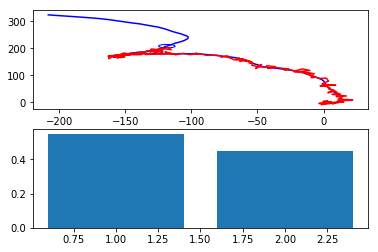

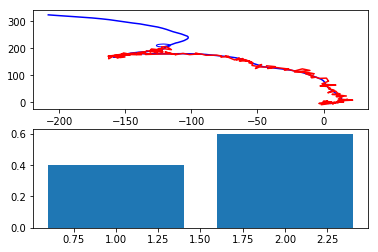

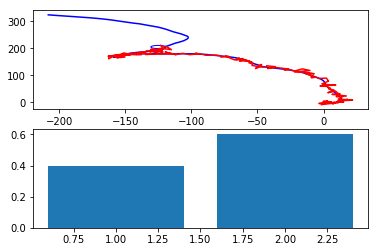

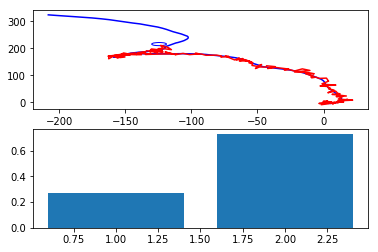

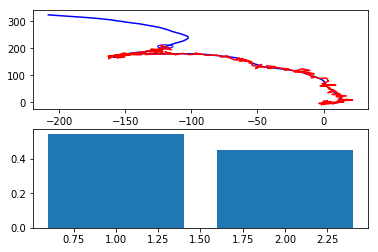

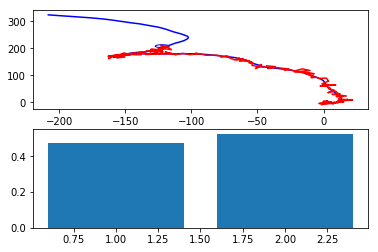

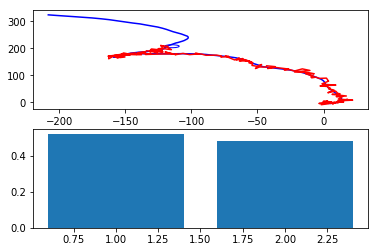

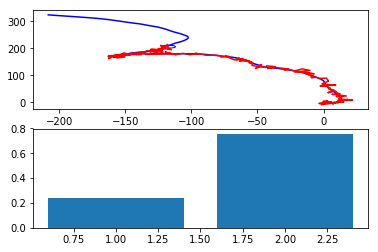

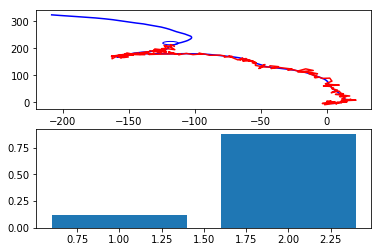

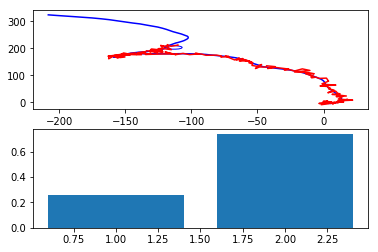

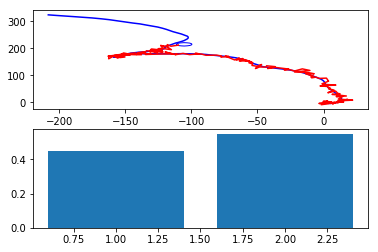

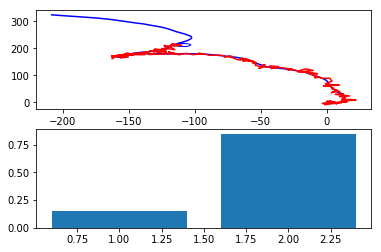

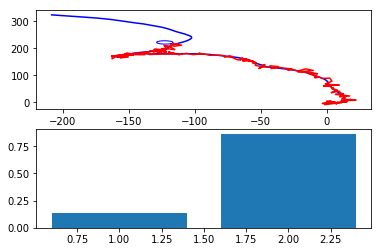

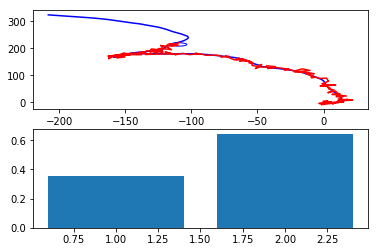

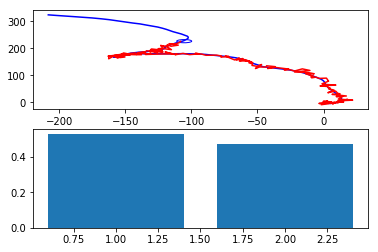

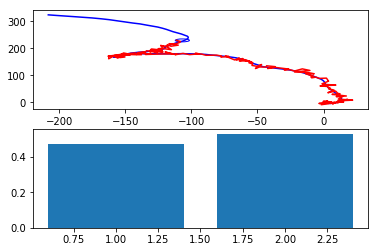

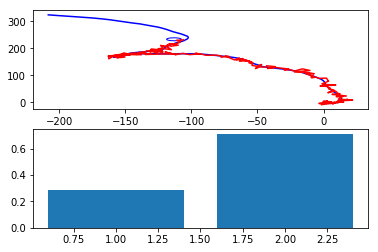

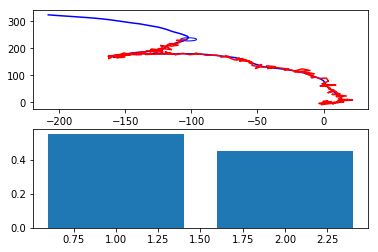

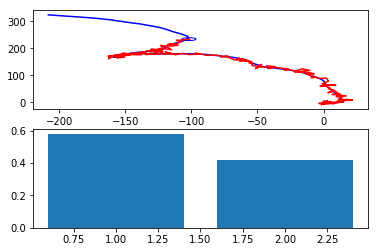

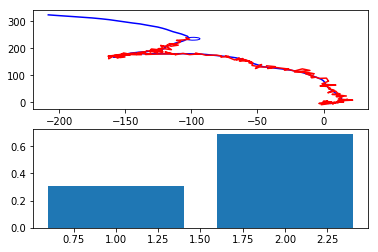

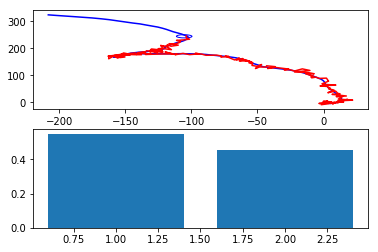

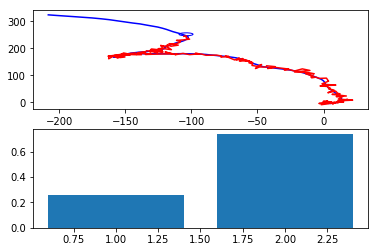

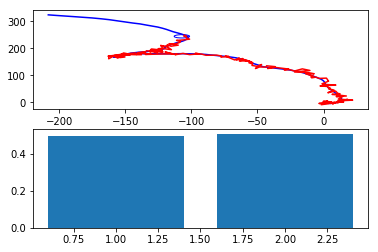

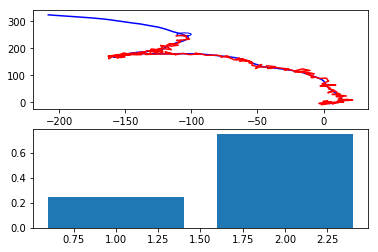

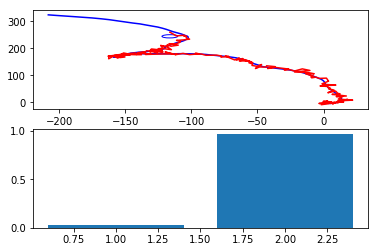

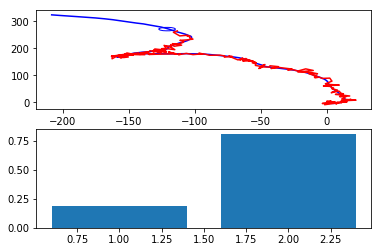

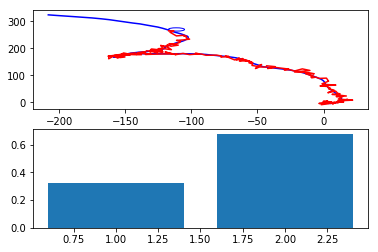

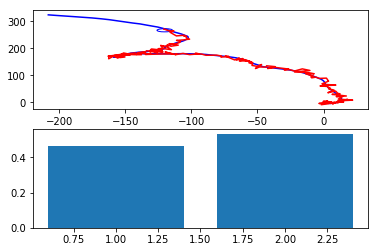

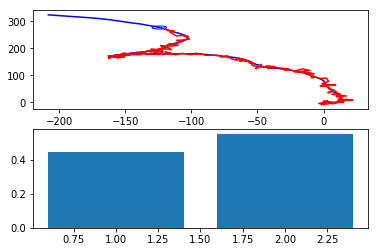

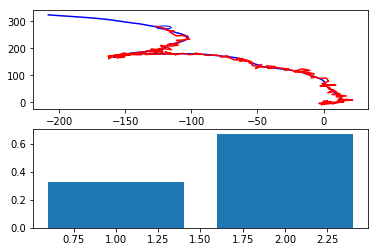

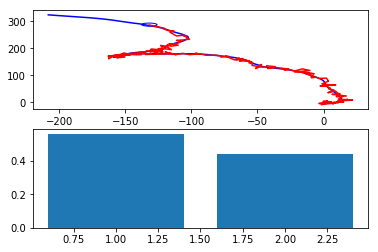

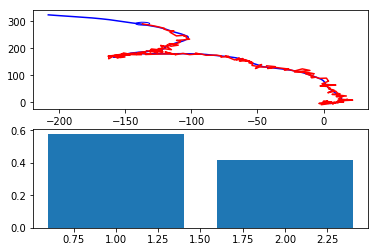

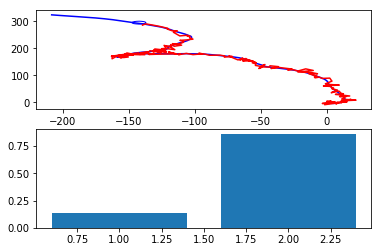

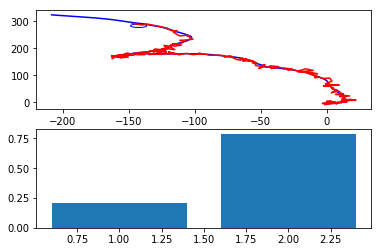

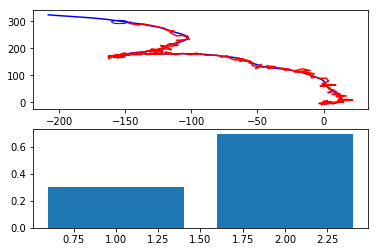

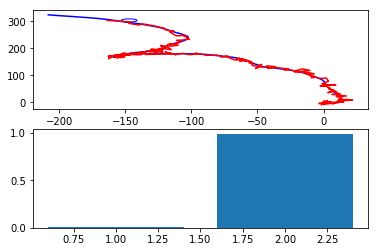

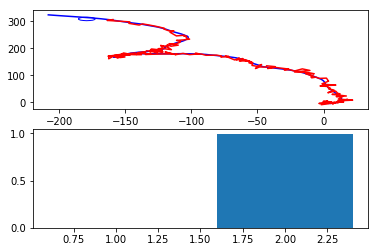

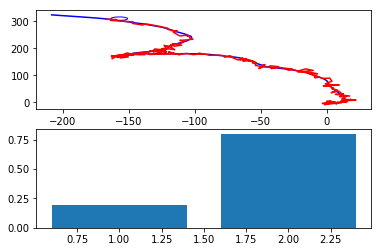

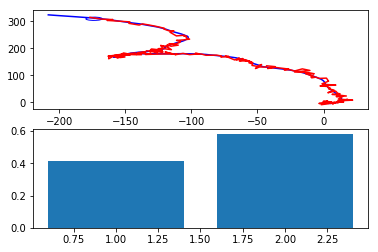

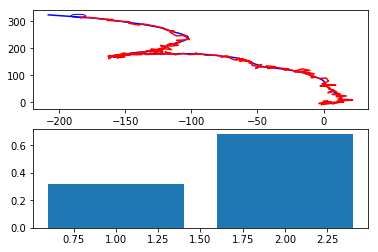

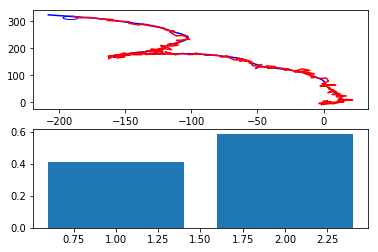

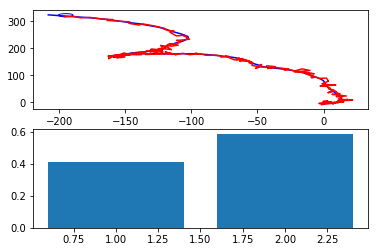

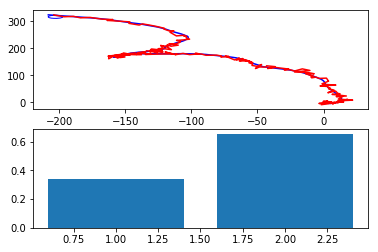

RMSE: 5.280151861516453


In [14]:
ft_transition_model_1 = CombinedLinearGaussianTransitionModel(
                        (ConstantVelocity(0.1),
                         ConstantVelocity(0.1)))
ft_transition_model_2 = CombinedLinearGaussianTransitionModel(
                        (ConstantVelocity(1.0),
                         ConstantVelocity(1.0)))
ft_measurement_noise = np.diag([0.1 ** 2, 0.1 ** 2])

ft_measurement_model = LinearGaussian(ndim_state=4, mapping=[0, 2],
                                   noise_covar=ft_measurement_noise)

ft_model_transition_matrix = np.array([[0.5, 0.5],
                                    [0.5, 0.5]])
ft_predictor_1 = KalmanPredictor(ft_transition_model_1)
ft_predictor_2 = KalmanPredictor(ft_transition_model_2)
ft_imm_predictor = IMMPredictor([ft_predictor_1, ft_predictor_2], ft_model_transition_matrix)

ft_updater = KalmanUpdater(ft_measurement_model)
ft_imm_updater = IMMUpdater([ft_updater, ft_updater], ft_model_transition_matrix)

ft_state_init = WeightedGaussianState(StateVector([[0], [0], [0], [0]]),
                                      CovarianceMatrix(np.diag([0.0, 0.0, 0.0, 0.0])),
                                      timestamp=timestamp_init,
                                      weight=0.5)

prior1 = copy(ft_state_init)
prior = GaussianMixtureState([prior1, prior1])
track = Track([copy(prior)])
track_error = []

for i in range(0, len(detection_track)-1):
    measurement = detection_track[i]
    fig, (ax1, ax2) = plt.subplots(2,1)
    # State prediction
    prediction = ft_imm_predictor.predict(track.state, timestamp=gt_time[i+1])
    # Measurement prediction
    meas_prediction = ft_imm_updater.predict_measurement(prediction)
    # State update
    hyp = SingleHypothesis(prediction, measurement)
    prior = ft_imm_updater.update(hyp)
    track.append(prior)
    track_error.append(ft_measurement_model.function(track[i].state_vector, np.zeros((2,1))) - ft_measurement_model.function(gt_track[i].state_vector, np.zeros((2,1))))
    
    # Generate plots
    ax1.cla()
    ax2.cla()
    # PLot true trajectory
    data = np.array([state.state_vector for state in gt_track])
    ax1.plot(data[:, 0], data[:, 2], 'b-')
    # PLot estimated trajectory
    data = np.array([state.state_vector for state in track.states])
    ax1.plot(data[:, 0], data[:, 2], 'r-')
    # Plot innovation covariance
    plot_cov_ellipse(meas_prediction.covar,
                     meas_prediction.mean, edgecolor='b',
                     facecolor='none', ax=ax1)
    # Plot estimated covariance
    plot_cov_ellipse(track.state.covar[[0, 2], :][:, [0, 2]],
                     track.state.mean[[0, 2], :], edgecolor='r',
                     facecolor='none', ax=ax1)
    # Visualise model weights
    ax2.bar([1,2], prior.weights.ravel())
    plt.pause(0.0001)

track_error = np.asarray(track_error)
track_error = np.squeeze(track_error)
rmse_tmp = []
for track_error_ in track_error:
    rmse_tmp.append(track_error_ @ track_error_.T)
rmse = np.sqrt(np.mean(np.array(rmse_tmp)))
print("RMSE: " + str(rmse))

Filter model. Testing with correct parameters.

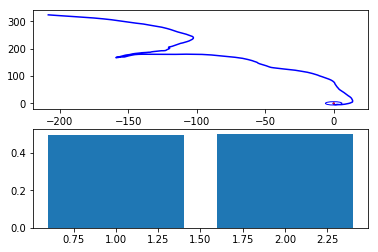

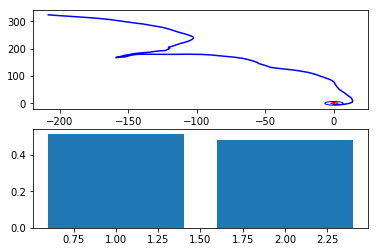

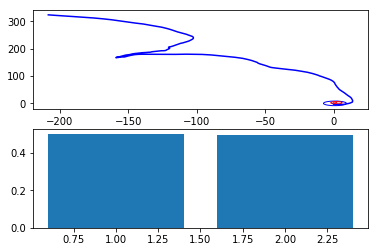

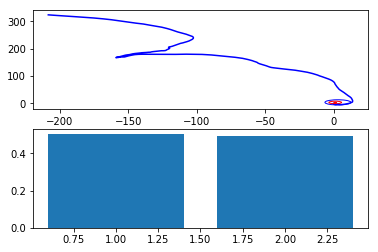

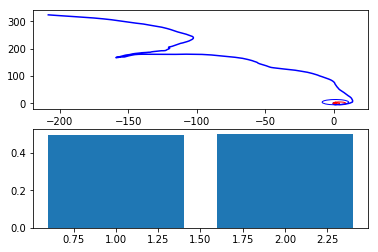

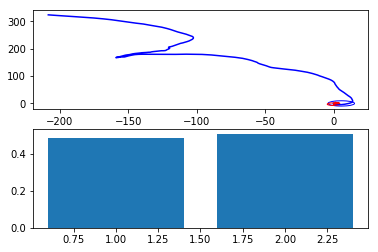

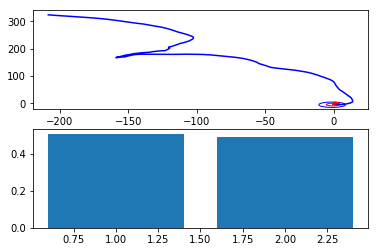

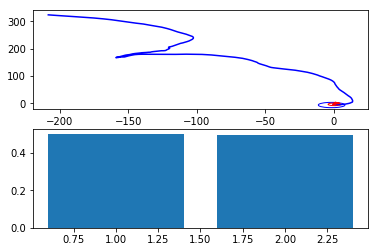

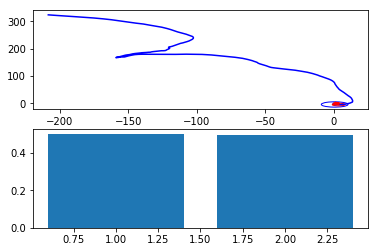

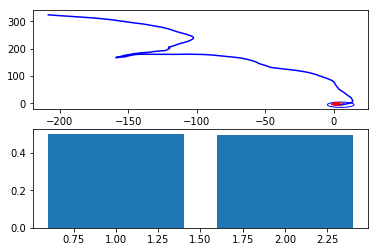

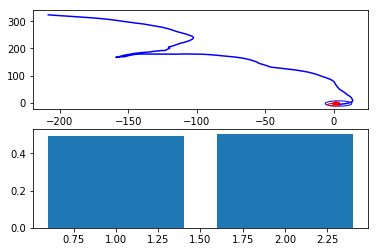

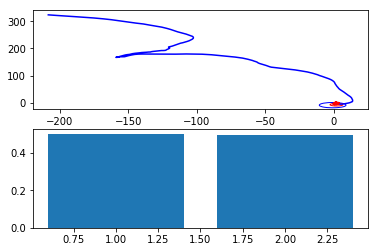

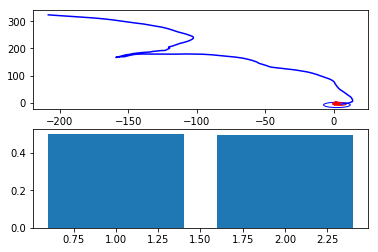

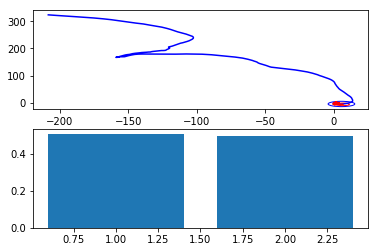

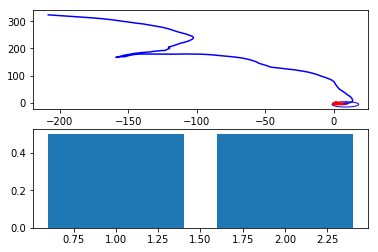

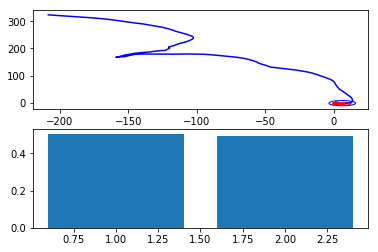

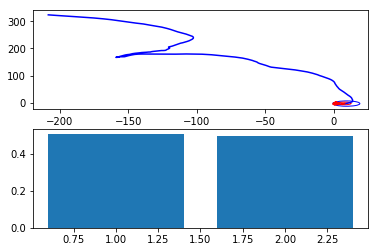

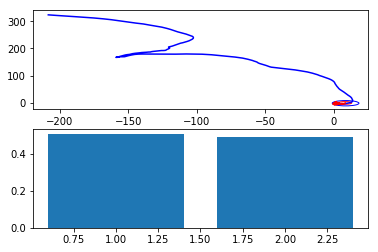

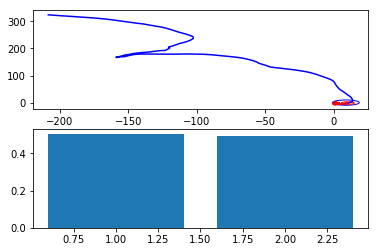

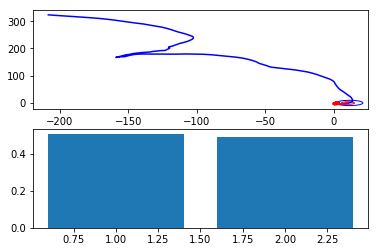

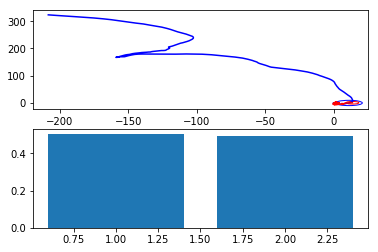

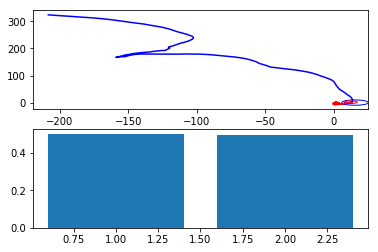

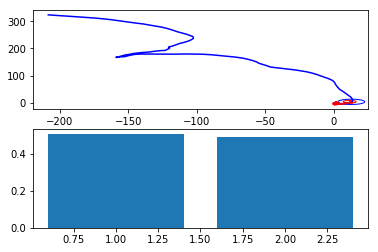

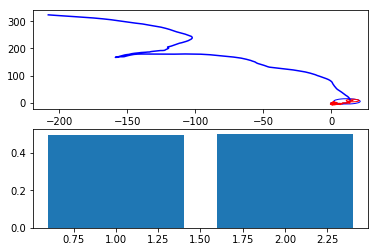

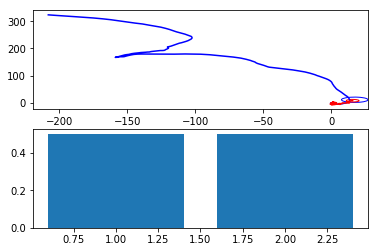

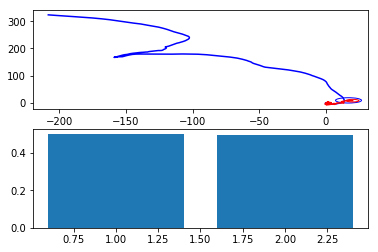

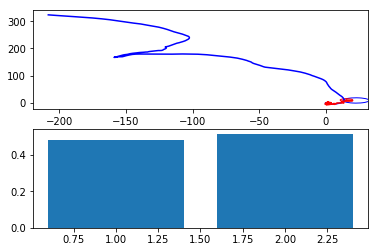

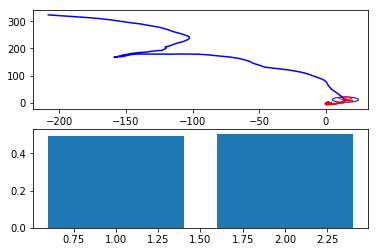

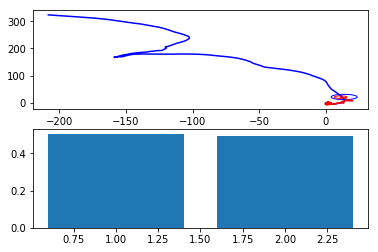

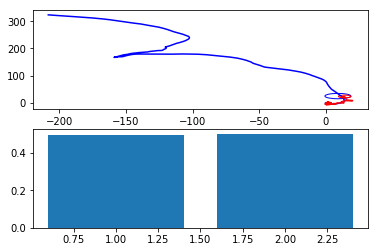

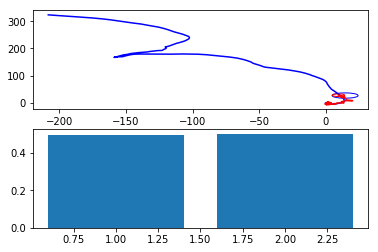

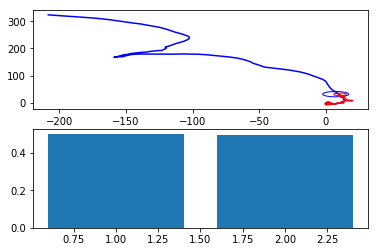

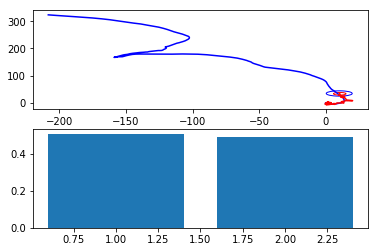

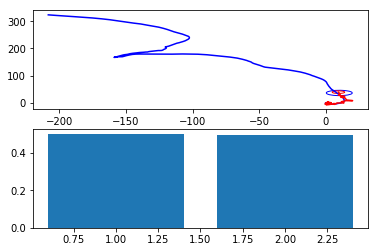

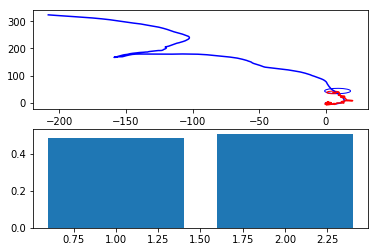

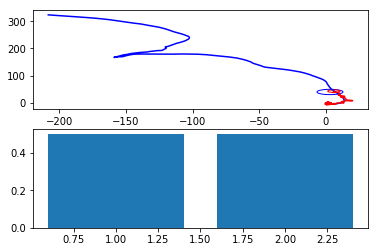

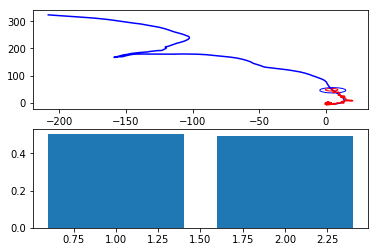

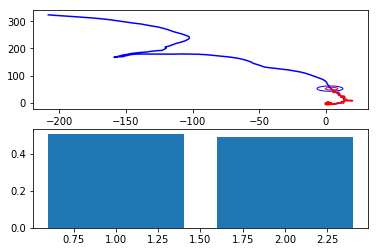

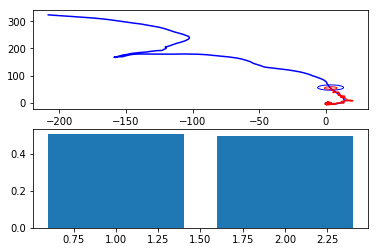

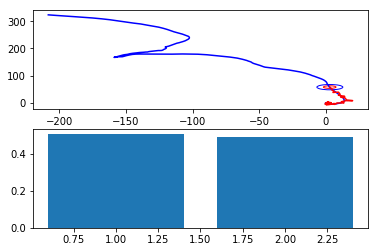

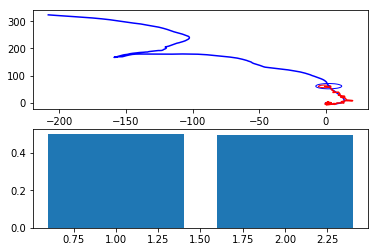

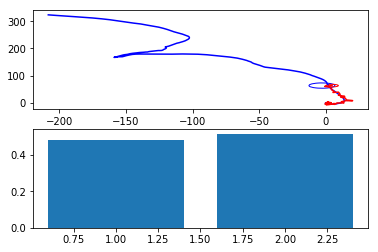

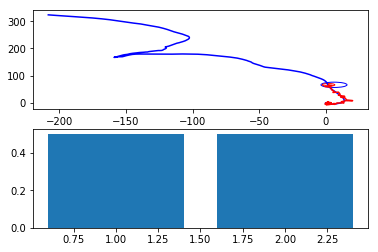

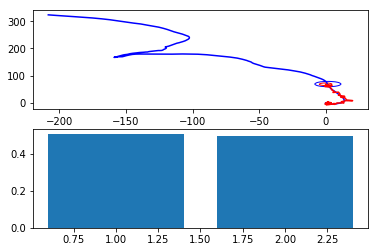

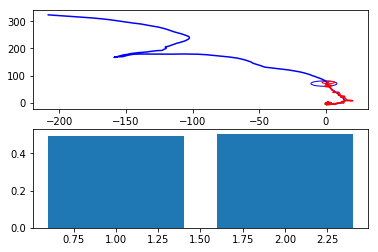

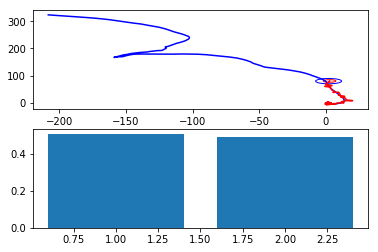

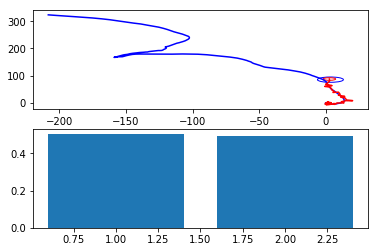

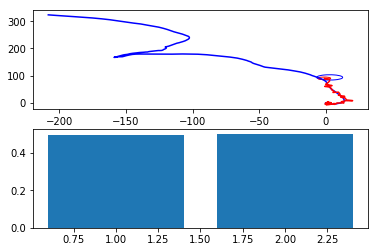

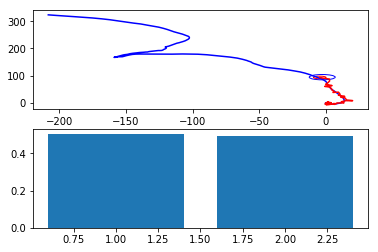

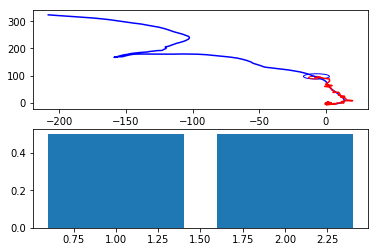

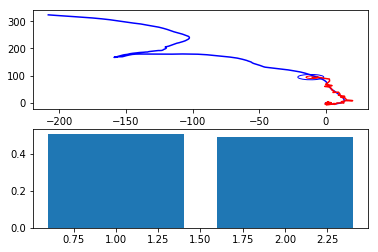

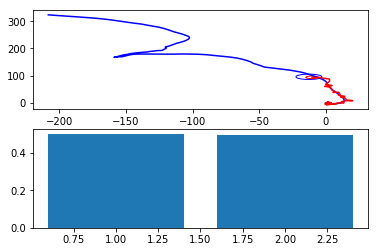

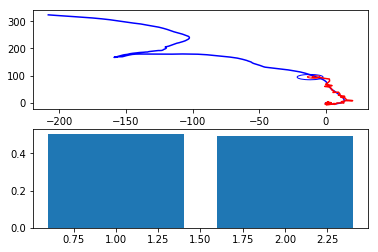

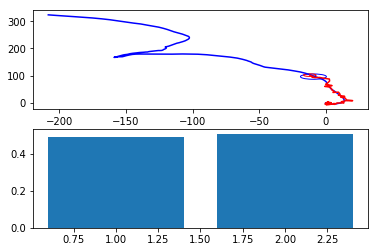

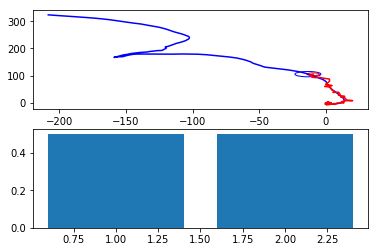

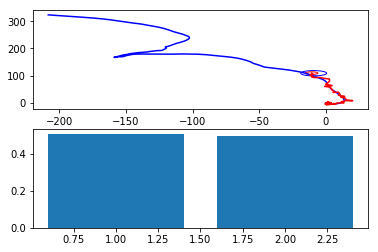

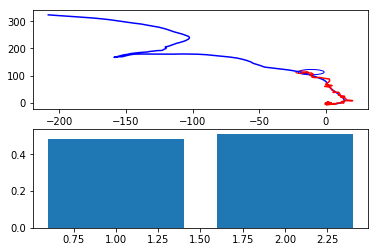

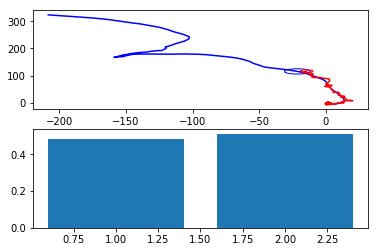

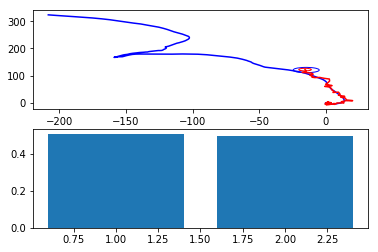

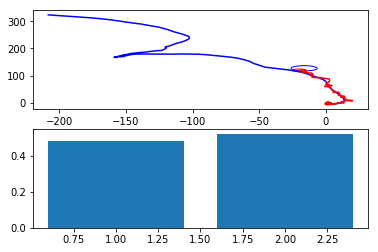

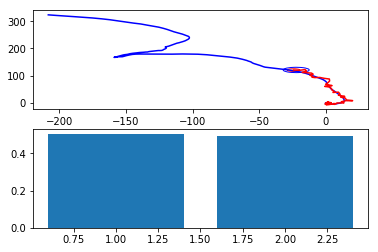

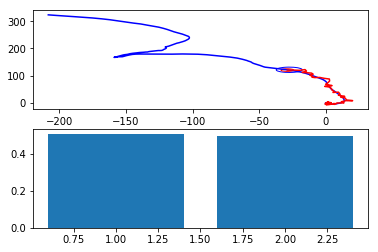

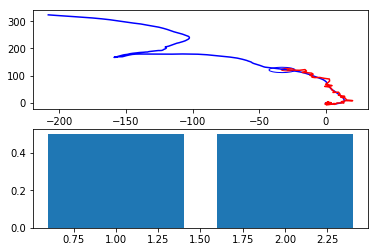

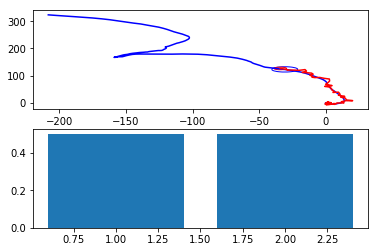

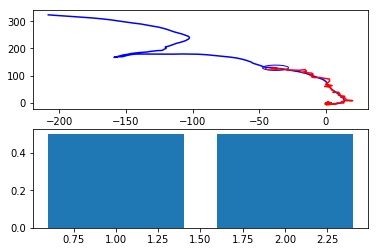

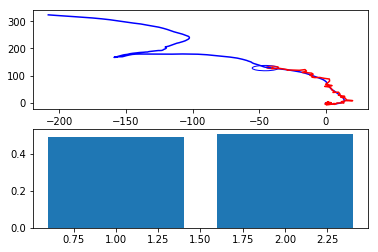

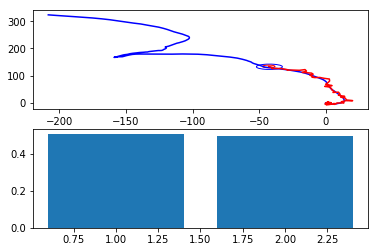

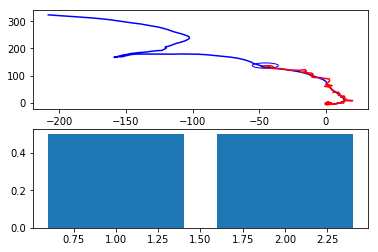

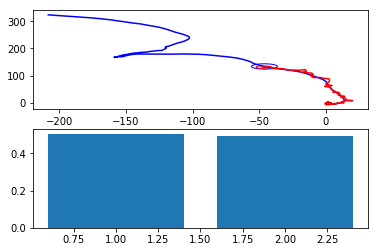

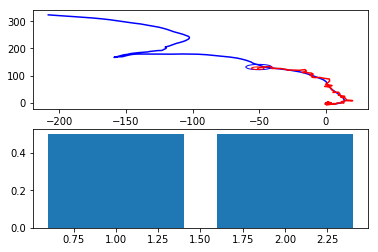

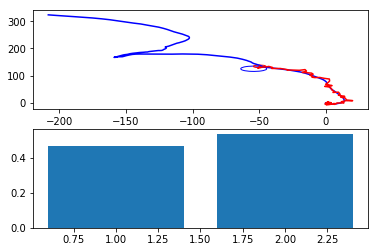

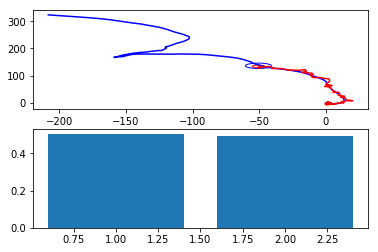

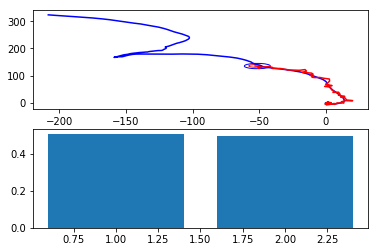

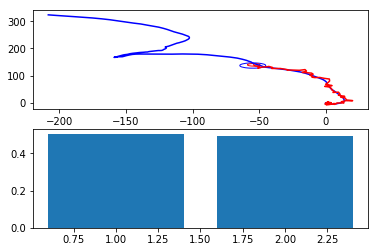

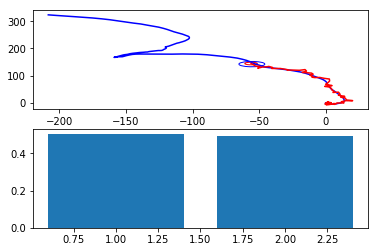

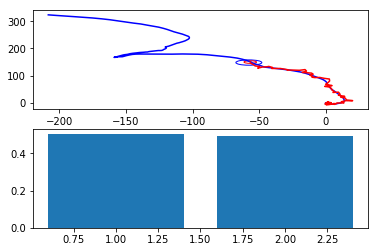

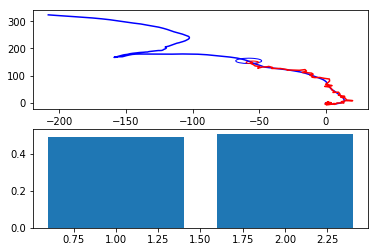

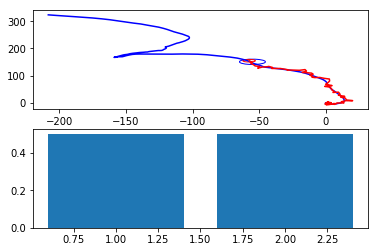

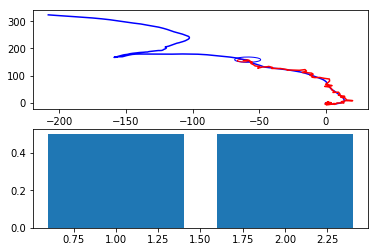

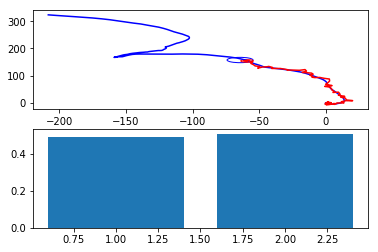

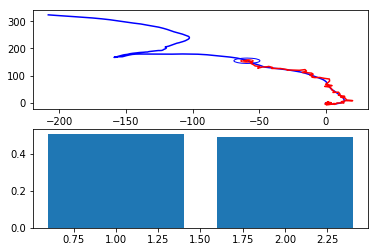

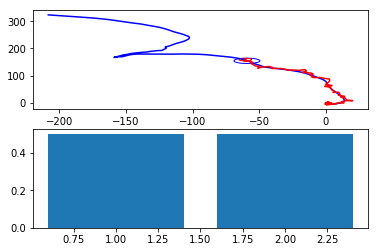

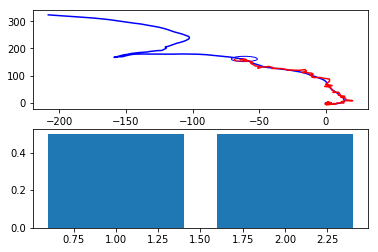

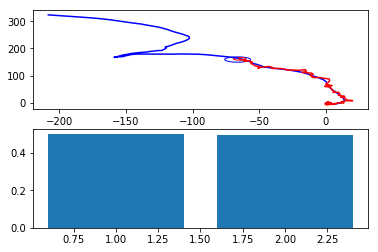

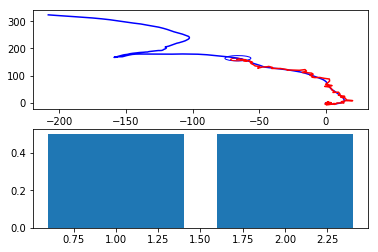

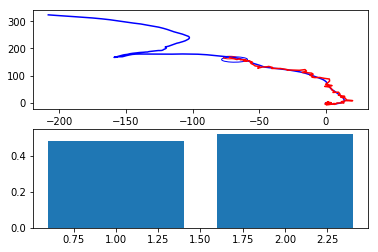

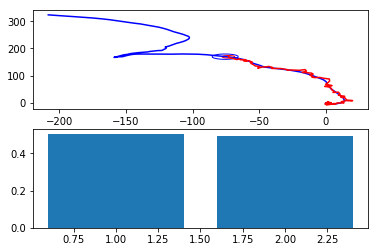

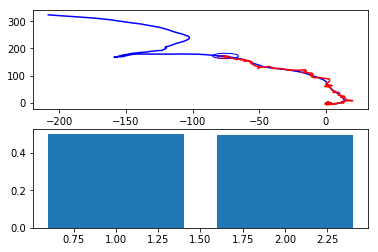

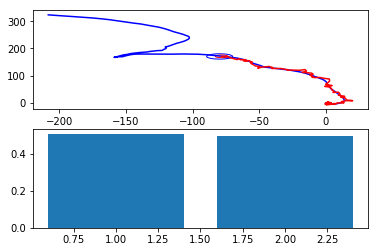

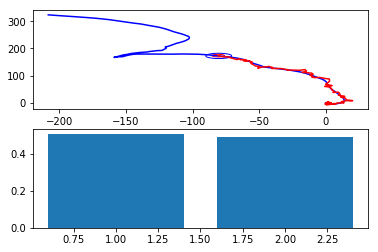

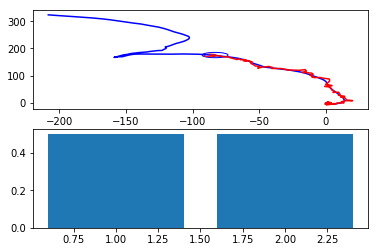

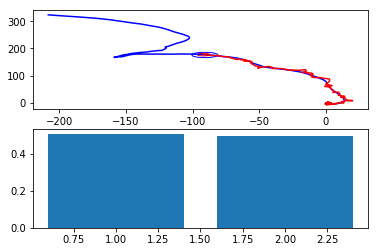

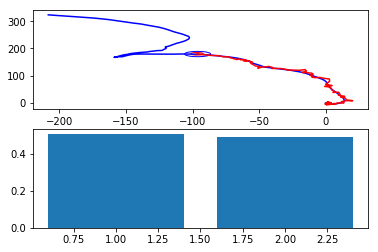

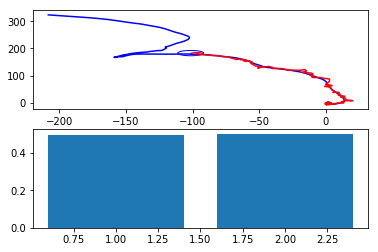

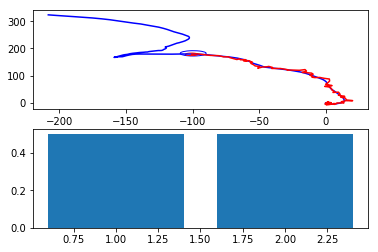

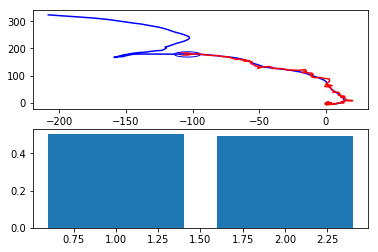

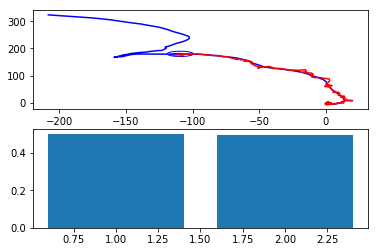

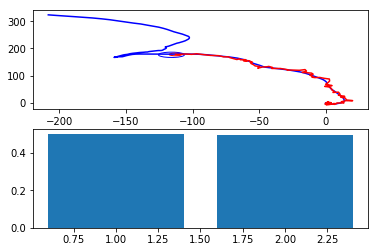

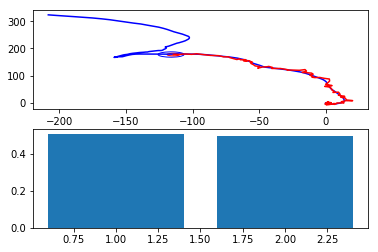

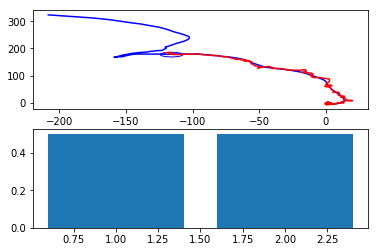

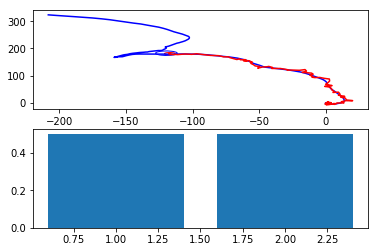

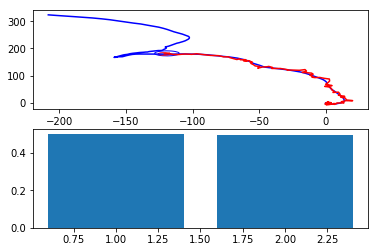

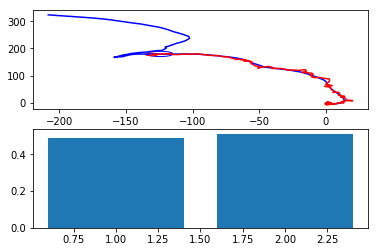

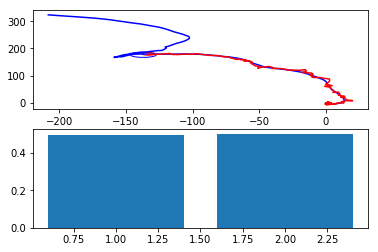

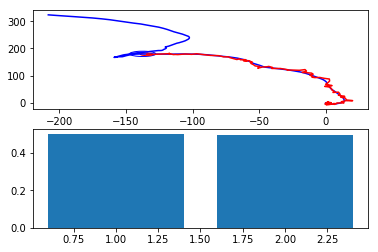

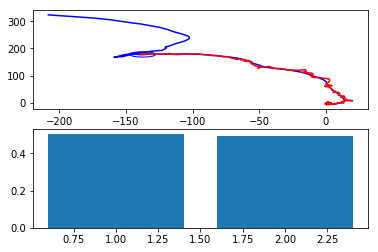

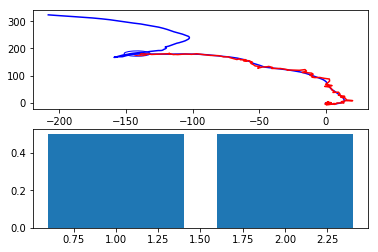

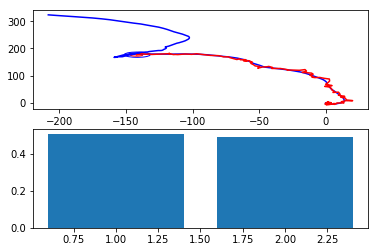

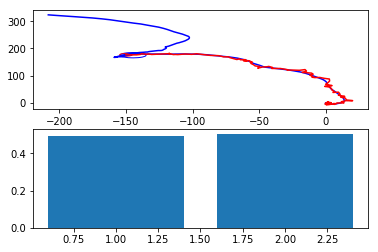

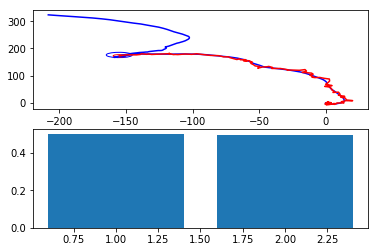

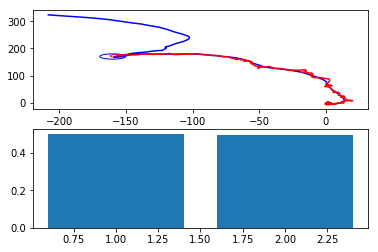

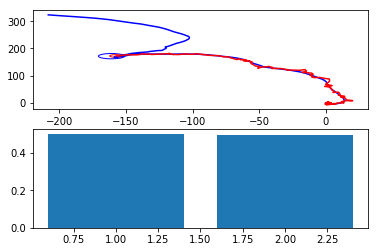

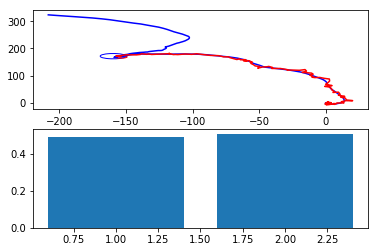

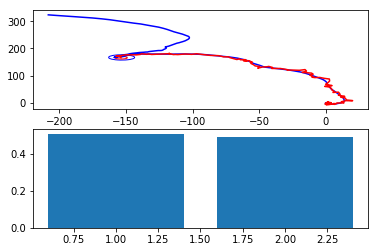

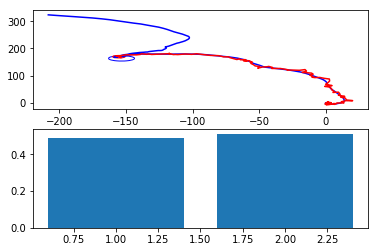

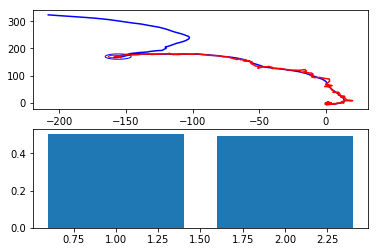

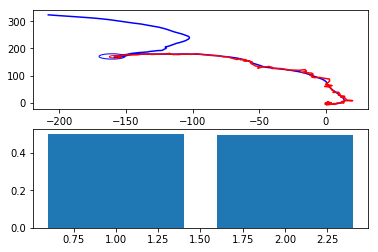

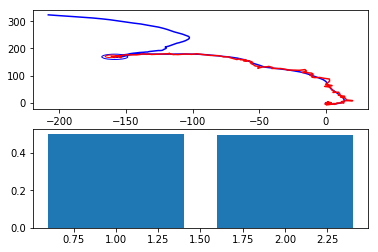

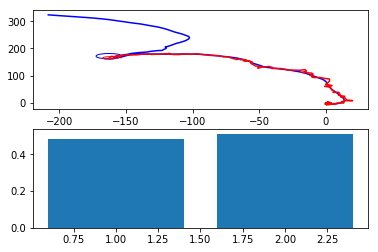

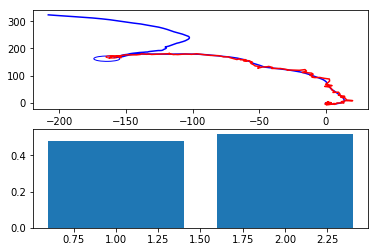

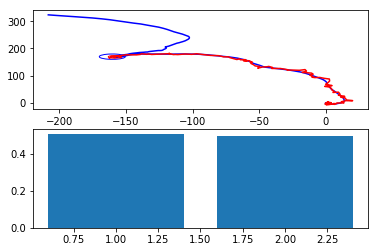

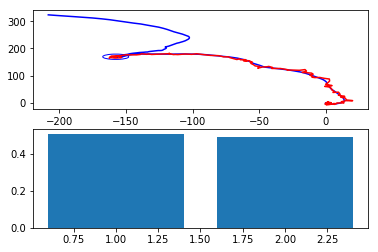

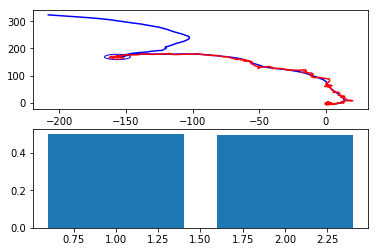

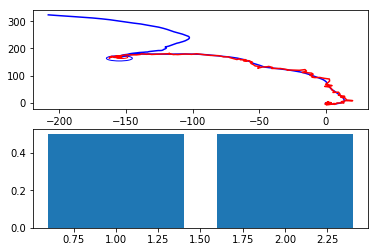

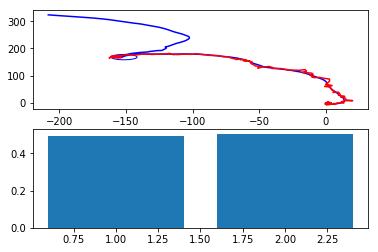

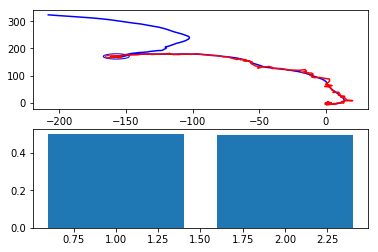

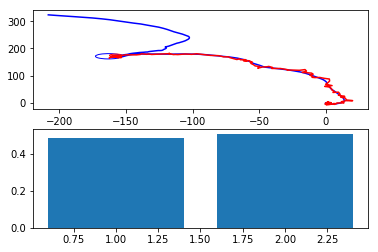

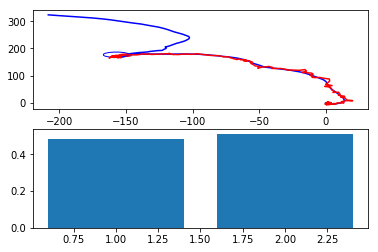

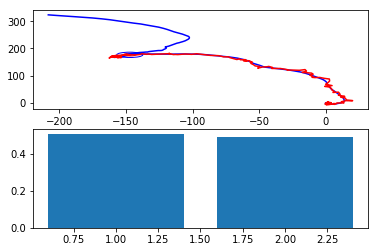

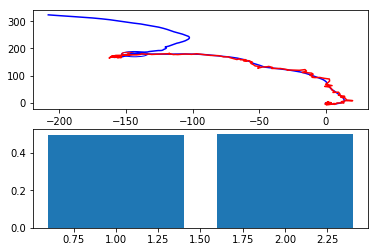

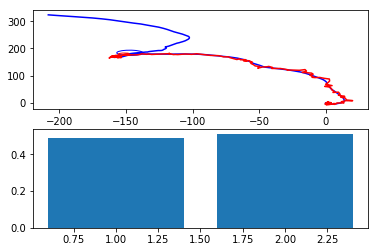

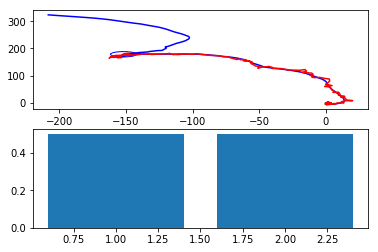

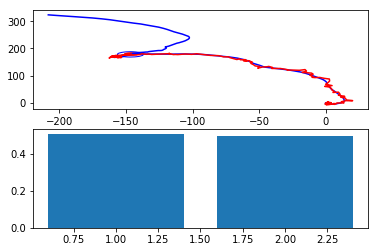

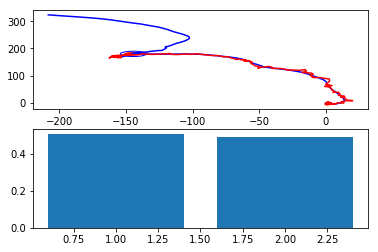

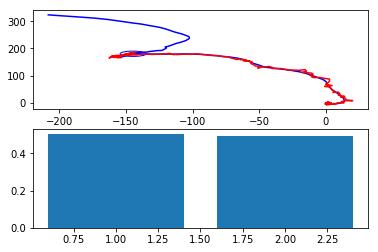

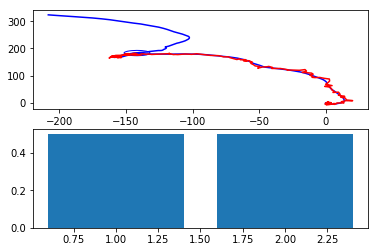

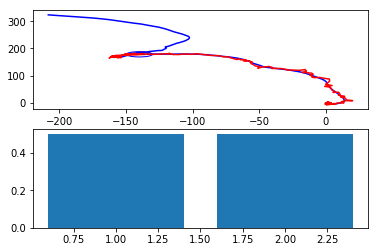

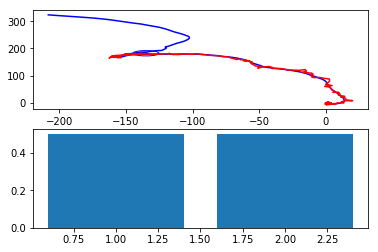

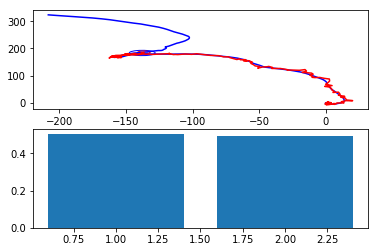

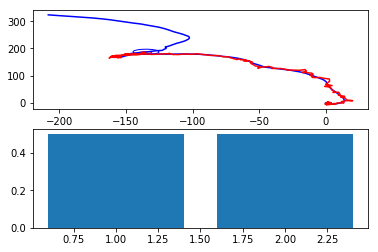

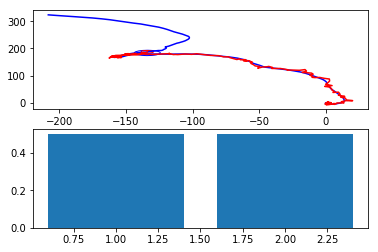

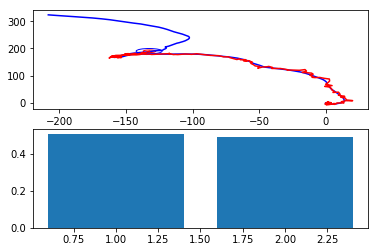

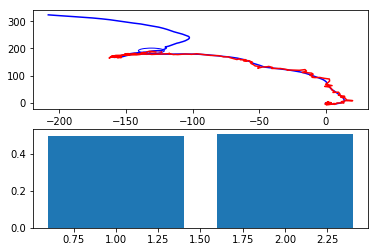

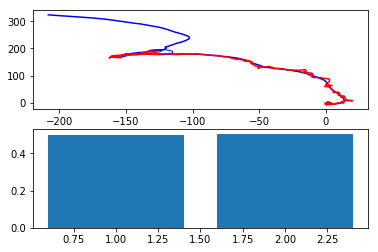

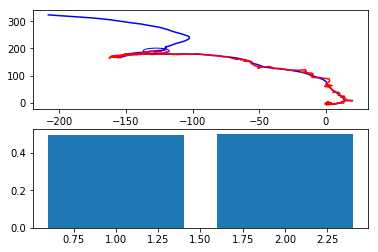

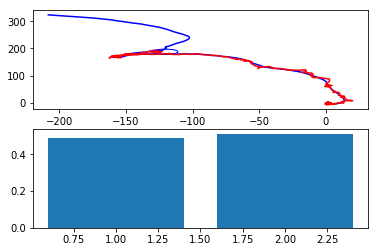

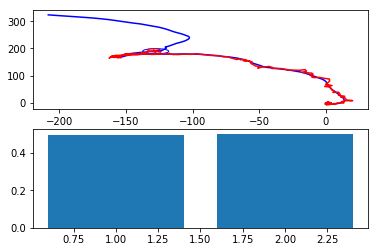

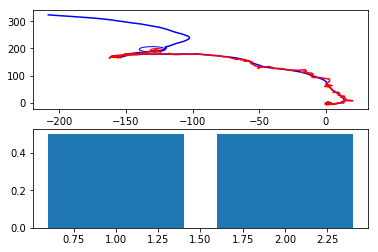

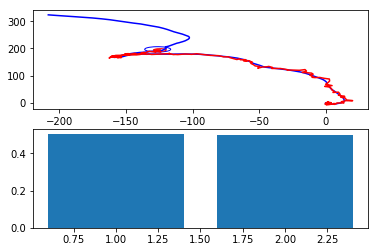

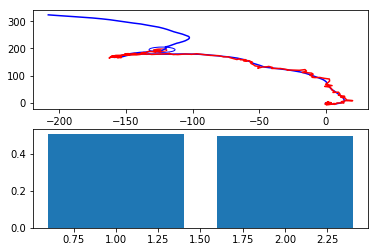

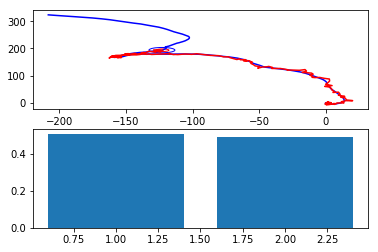

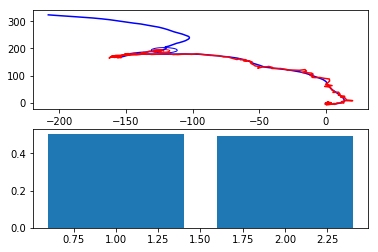

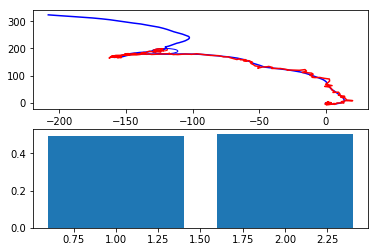

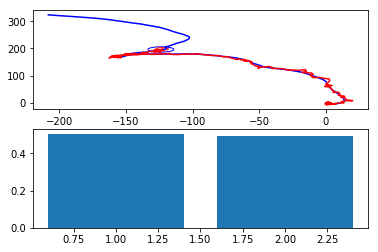

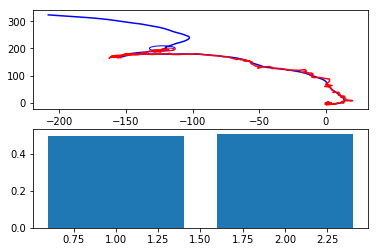

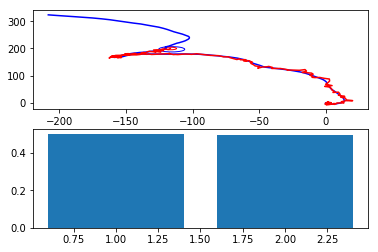

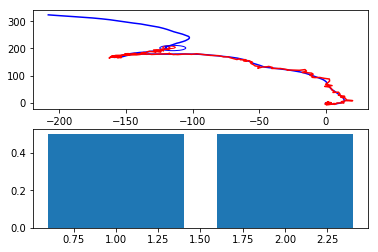

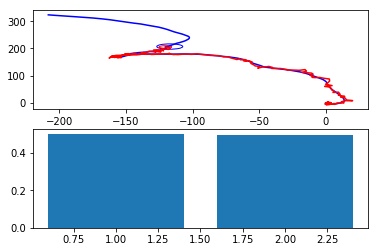

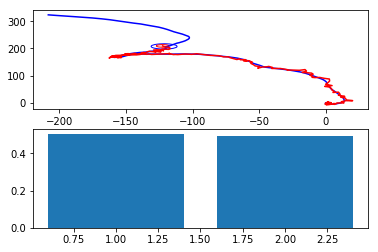

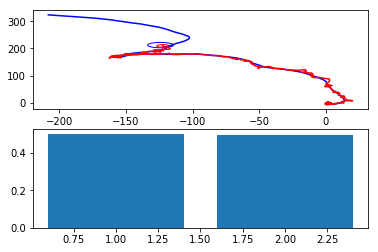

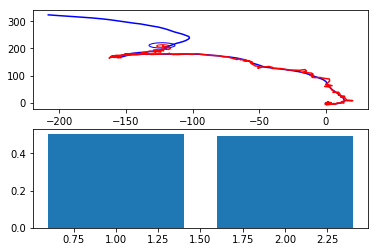

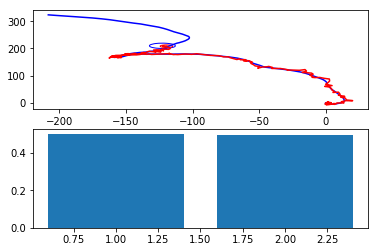

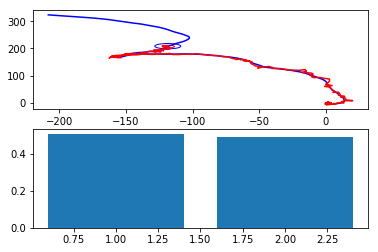

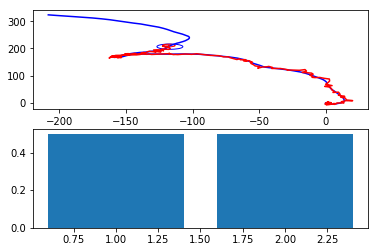

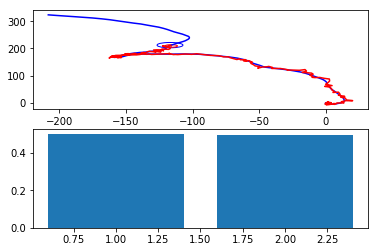

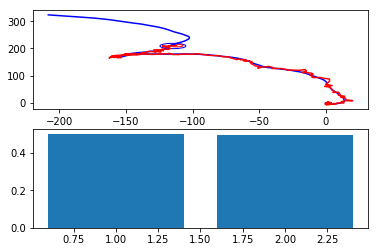

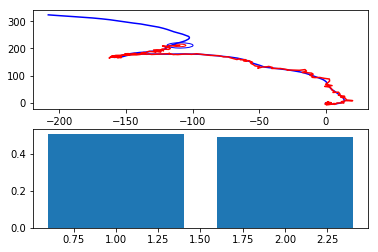

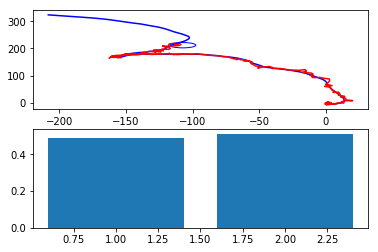

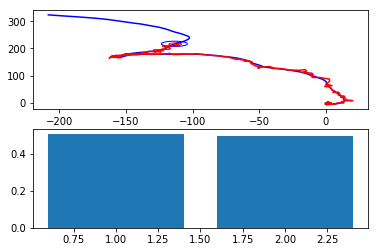

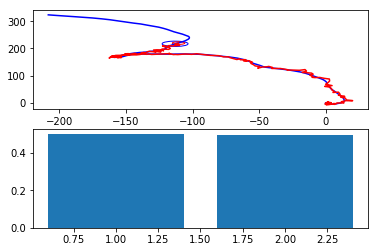

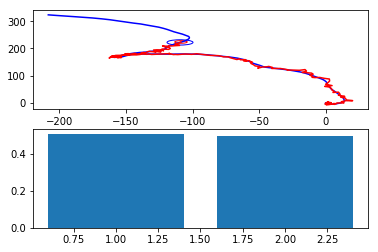

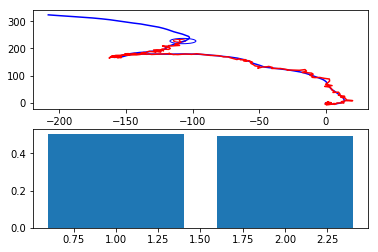

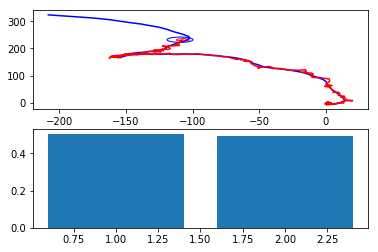

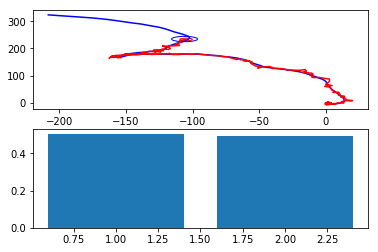

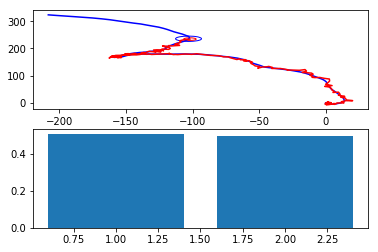

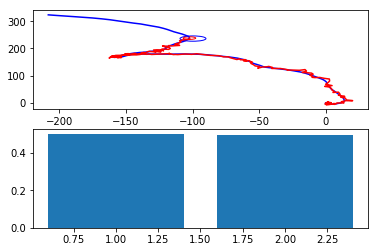

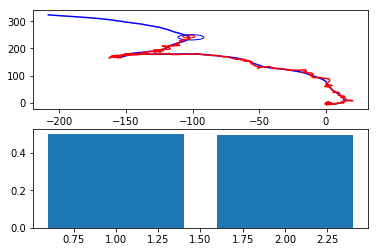

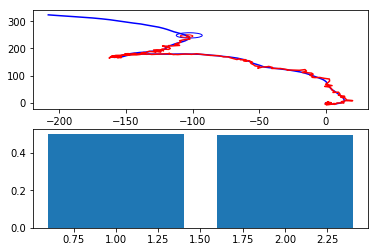

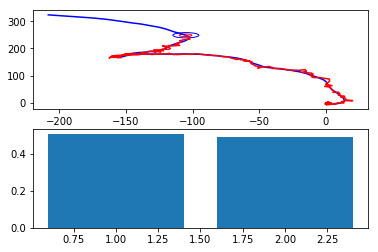

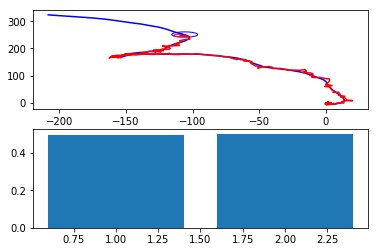

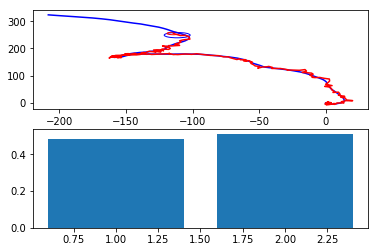

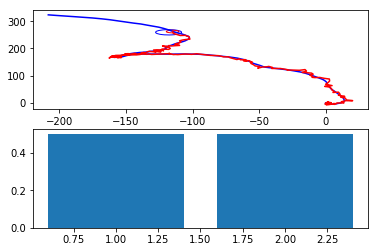

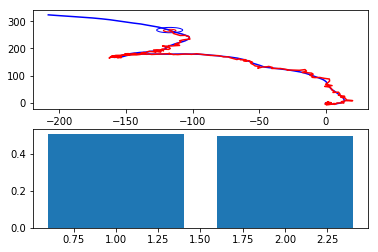

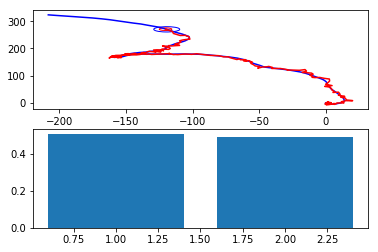

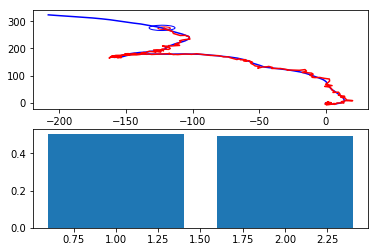

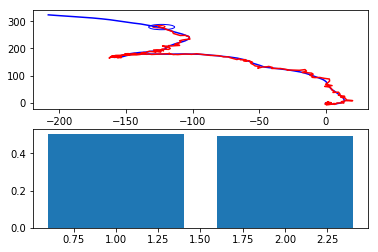

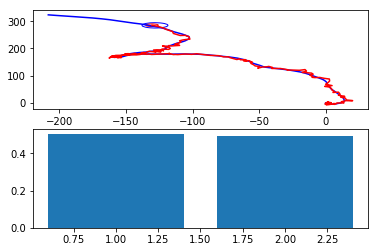

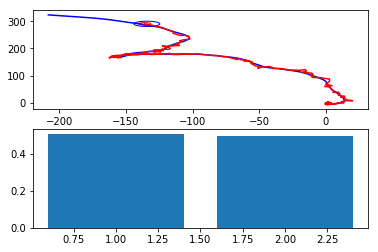

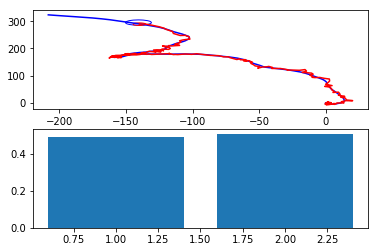

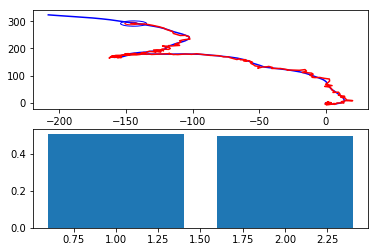

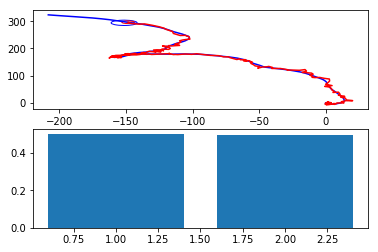

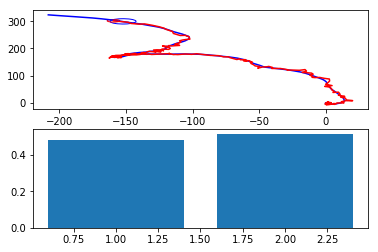

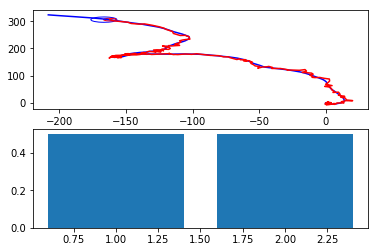

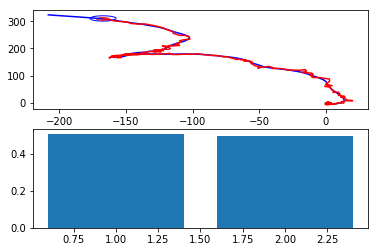

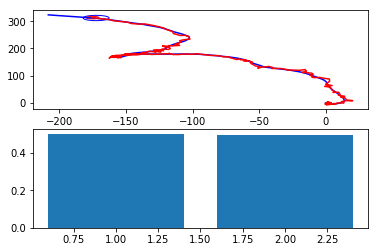

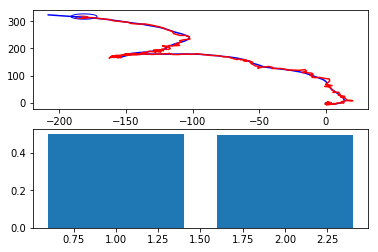

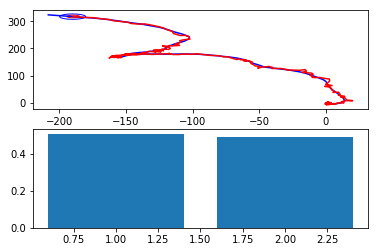

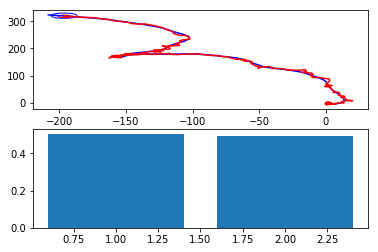

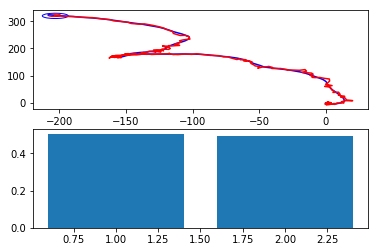

RMSE: 4.3585892714214145


In [15]:
model_transition_matrix = np.array([[0.5, 0.5],
                                    [0.5, 0.5]])

predictor_1 = KalmanPredictor(gt_transition_model_1)
predictor_2 = KalmanPredictor(gt_transition_model_2)
imm_predictor = IMMPredictor([predictor_1, predictor_2],
                             model_transition_matrix)

updater = KalmanUpdater(measurement_model)
imm_updater = IMMUpdater([updater, updater], model_transition_matrix)

prior1 = copy(ft_state_init)
prior = GaussianMixtureState([prior1, prior1])
track = Track([copy(prior)])
track_error = []

for i in range(0, len(detection_track)-1):
    measurement = detection_track[i]
    # State prediction
    prediction = imm_predictor.predict(track.state, timestamp=gt_time[i+1])
    # Measurement prediction
    meas_prediction = imm_updater.predict_measurement(prediction)
    # State update
    hyp = SingleHypothesis(prediction, measurement)
    prior = imm_updater.update(hyp)
    track.append(prior)
    track_error.append(ft_measurement_model.function(track[i].state_vector, np.zeros((2,1))) - ft_measurement_model.function(gt_track[i].state_vector, np.zeros((2,1))))
    # print(ft_measurement_model.function(track[i].state_vector, np.zeros((2,1))))
    # print(ft_measurement_model.function(gt_track[i].state_vector, np.zeros((2,1))))
    # print('----------------------')
    
    fig, (ax1, ax2) = plt.subplots(2,1)
    # Generate plots
    ax1.cla()
    ax2.cla()
    # PLot true trajectory
    data = np.array([state.state_vector for state in gt_track])
    ax1.plot(data[:, 0], data[:, 2], 'b-')
    # PLot estimated trajectory
    data = np.array([state.state_vector for state in track.states])
    ax1.plot(data[:, 0], data[:, 2], 'r-')
    # Plot innovation covariance
    plot_cov_ellipse(meas_prediction.covar,
                     meas_prediction.mean, edgecolor='b',
                     facecolor='none', ax=ax1)
    # Plot estimated covariance
    plot_cov_ellipse(track.state.covar[[0, 2], :][:, [0, 2]],
                     track.state.mean[[0, 2], :], edgecolor='r',
                     facecolor='none', ax=ax1)
    # Visualise model weights
    ax2.bar([1,2], prior.weights.ravel())
    plt.pause(0.0001)
    

track_error = np.asarray(track_error)
track_error = np.squeeze(track_error)
rmse_tmp = []
for track_error_ in track_error:
    rmse_tmp.append(track_error_ @ track_error_.T)
rmse = np.sqrt(np.mean(np.array(rmse_tmp)))
print("RMSE: " + str(rmse))

In [13]:
len(gt_time)

200

EMGPB2

In [ ]:
F = np.asarray([
        [1, 0, 1, 0],
        [0, 1, 0, 1],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])
H = np.asanyarray([
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

g1 = Gaussian(np.zeros([4, 1]), 10.0*np.eye(4))
g2 = Gaussian(np.zeros([4, 1]), 10.0*np.eye(4))
initial_gmm_state = GMM([g1, g2])

# measurements = 5 * np.random.randn(200, 2, 1) + 1

measurements = np.loadtxt(r'data/measurement2.csv', delimiter=',')
measurements = np.expand_dims(measurements, axis=-1)

gmmsequence = GMMSequence(measurements, initial_gmm_state)

m1 = LinearModel(F, get_Q(5.0), H, 1.0*np.eye(2))
m2 = LinearModel(F, get_Q(0.1), H, 0.1*np.eye(2))
initial_models = [m1, m2]

Z = np.ones([2, 2]) / 2
dataset = [gmmsequence]

new_models, Z, dataset, LL = SKF.EM(dataset, initial_models, Z,
                                    max_iters=100, threshold=0.00001, learn_H=True, learn_R=True,
                                    learn_A=True, learn_Q=True, learn_init_state=False, learn_Z=True,
                                    keep_Q_structure=False, diagonal_Q=False, wishart_prior=False)